In [1303]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools

In [1304]:
#Currently working with a small tracking cost. Will implement the cost to go constraint now. 

In [1305]:
#Fixes to try: 
#1. Get discrete dynamics jacobians with RK4. Matrix exponential is only exact for LTI systems. (done)
#2. Implement the second order correction (done) (not needed, it was a bug with the reference trajectory)
#3. More conservative half space constraint (done)
#4. Change the c at each knot point according to the maximum delta x deviation possible

#4. Current orbit is not exactly periodic (xend - xinitial). Set the reference trajectory to that orbit revd twice instead of concatenating two arrays (potential fix)

In [1306]:
#Current bug: reference_trajectory2 has to be updated in the half solve. Currently it is the wrong dynamics constraint since the reference trajectory is
# from the beginning.  

In [1307]:
# #scaled dynamics in the user defined custom units  
# function threebp_dynamics_scaled(x, u)
    
#     q_original = zeros(eltype(x),3)
#     v_original = zeros(eltype(x),3)
#     q_original = x[1:3]*custom_position_scale 
#     v_original = x[4:6]*custom_velocity_scale
    
#     x_original = [q_original; v_original]
    
#     if Lagrange_Point == "L1"
        
#         #L1 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [0.8369180073169304, 0,0,0,0,0]

#     else
        
#         #L2 Lagrange Point for Earth Moon System (from the lagrange file)
#         L = [1.1556799130947355,0,0,0,0,0]

#     end
    
#     #get it back to original units and without the L1 shift  
#     x_original_unshift = x_original+L
    
#     ẋ_original = zeros(eltype(x),6)
    
#     #calculate the original xdot (no scaling)
#     ẋ_original = threebp_dynamics(x_original_unshift, u)

#     #then scale these dynamics
#     v_scaled = ẋ_original[1:3]/custom_velocity_scale
    
#     a_scaled = ẋ_original[4:6]/custom_accel_scale
        
#     ẋ_scaled = [v_scaled; a_scaled]

#     return ẋ_scaled
# end

In [1308]:
#from the Lyaponov orbit
#x0_lyapunov = [ 1.1556814491008298,
# -1.4319993886822296e-21,
#  0.0,
#  2.2212106056655213e-21,
# -8.333136405918907e-6,
#  0.0]



 #lyapunov_period = 3.3732524857835884


In [1309]:
#parameters for Earth Moon System
μ = 1.901109735892602e-7
μ1 = 1-μ
μ2 = μ

#position of mass 1
pose_m1 = [-μ, 0, 0]

#position of mass 2
pose_m2 = [1-μ, 0, 0]

#value obtained from 3BP textbook (original)
L = 238529 #in km - distance between centers of m1 and m2
#V_ = 1.025 #in km/s - orbital velocity of m1
#T_ = 2.361e6 #in seconds - orbital period of m1 and m2


#working
#########################################################################################
#updated for time unit to be in days
T_ = 18913/86400 #in days - orbital period of m1 and m2
time_scale = T_ #/(2*pi)
#no need to divide by 2 pi for this time scale!

#time unit of days
V_ = L/time_scale
acceleration_scale = L/((time_scale)^2)
##########################################################################################

#state of the L1 and L2 Lagrange points (computed offline)
XL1 = [0.99601828, 0, 0, 0, 0, 0]
XL2 = [1.00399194, 0, 0, 0, 0, 0]

6-element Vector{Float64}:
 1.00399194
 0.0
 0.0
 0.0
 0.0
 0.0

In [1310]:
T_ 

0.21890046296296295

In [1311]:
function effective_potential(X)
    x = X[1]
    y = X[2]
    z = X[3]

    r1 = sqrt((x+μ2)^2 + y^2 + z^2) 
    r2 = sqrt((x-μ1)^2 + y^2 + z^2)
    #assuming m3 is unit mass
   
    U = (-μ1/r1)-(μ2/r2)-0.5*(x^2+y^2)
   
    return U
    
end

effective_potential (generic function with 1 method)

In [1312]:
function three_body_prob_dynamics(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]

    ẋ = zeros(eltype(x),6)
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] 
    ẋ[5] = -2*v[1] - U_q[2]
    ẋ[6] = -U_q[3]

    return ẋ
end

three_body_prob_dynamics (generic function with 1 method)

In [1313]:
#x[1:6] -> state
#x[7:9] -> control inputs

#coming in with SI units
function three_body_prob_dynamics_wcontrol(x)
    
    q = zeros(eltype(x),3)
    v = zeros(eltype(x),3)
    q = x[1:3]
    v = x[4:6]
    u = x[7:9]

    ẋ = zeros(eltype(x),9)
    
    U_q = zeros(eltype(x),3)
    
    U_q = (ForwardDiff.gradient(_x -> effective_potential(_x), q))
        
    ẋ[1:3] = v
    ẋ[4] = 2*v[2] - U_q[1] + u[1] 
    ẋ[5] = -2*v[1] - U_q[2] + u[2]
    ẋ[6] = -U_q[3] + u[3]
    
    #zero order hold on the controls 
    ẋ[7:9] = zeros(3)

    return ẋ
end

three_body_prob_dynamics_wcontrol (generic function with 1 method)

In [1314]:
#this just scales the dynamics by L and V_

In [1315]:
#inputs are in the custom SI unit scale

function three_body_prob_dynamics_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    
    x_original = [q_original; v_original]

    #original is in the CR3BP units
    ẋ_original = zeros(eltype(x),6)

    #calculate the original xdot (no scaling)

    ẋ_original = three_body_prob_dynamics(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_scaled (generic function with 1 method)

In [1316]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled(x)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = x[7:9]/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled; u_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled (generic function with 1 method)

In [1317]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL_wcontrol!(du, u, p, t)
    
    #original CR3BP units
    #du[1:9] = three_body_prob_dynamics_wcontrol(u[1:9])

    #scaled units
    du[1:9] = three_body_prob_dynamics_wcontrol_scaled(u[1:9])
    
end

ST_and_dynamics_DFJL_wcontrol! (generic function with 1 method)

In [1318]:
#ensure that the x_0 coming in and the period are in scaled units

function dynamics_wcontrol_integrate(x_0,period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL_wcontrol!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_wcontrol_integrate (generic function with 1 method)

In [1319]:
#input is the initial condition
#control trajectory u (size N-1)

#integrate every half orbit

#u is size 20

#40 knot points in one rev. each of them are equally spaced apart


#ensure everything is in scaled units
function integrate_halfperiod(x_0, u)
    
    #u will be size 20
    
    #x trajectory not delta x 

    xtraj = zeros(6, 21)

    xtraj[:,1] = x_0

    #go through all the controls
    for i=1:20
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        #has the scaling included
        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)

        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
        
    end
    
    #this is size N. 21. Element 21 is the new 1
    return xtraj
        
end

integrate_halfperiod (generic function with 1 method)

In [1320]:
function integrate_oneperiod(x_0, u)
    
    #u will be size 40 since we only want to apply the controls for one rev
    
    #x trajectory not delta x 

    xtraj = zeros(6, N_period)

    xtraj[:,1] = x_0

    for i=1:N_period-1
        
        #integrate the nonlinear dynamics 1 timstep forward
        x_0_non = [xtraj[:,i]; u[:,i]]

        solution_in = dynamics_wcontrol_integrate(x_0_non, Δt)
        #this is the next state
        all_state_next = get_state_wcontrol(solution_in)

        xtraj[:,i+1] = all_state_next[1:6, end]
    end
    
    #this is size N. 40 for this case
    return xtraj
        
end

integrate_oneperiod (generic function with 1 method)

In [1321]:
#ODE for the state transition matrix 

function phi_ode(z)
    
    #state vector
    x = z[1:6]
    
    #state transition matrix
    Φ = reshape(z[7:end], (6,6))
    
    #Find the dynamics jacobian at the state vector (CR3BP dynamics)
    #F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics(dx), x)

    #scaled dynamics
    F =  ForwardDiff.jacobian(dx -> three_body_prob_dynamics_scaled(dx), x)
    
    #Differential Equation of State transition Matrix
    Φ_dot = F*Φ
    
    return vec(Φ_dot)
    
end

phi_ode (generic function with 1 method)

In [1322]:
#3BP dynamics and state transition matrix dynamics in one function 
function ST_and_dynamics(z)
    x = z[1:6]
    Φ = z[7:end]
    
    x_dot = three_body_prob_dynamics_scaled(x)
    Φ_dot = phi_ode(z)
    
    z_dot = [x_dot; Φ_dot]
    
    return z_dot
end

ST_and_dynamics (generic function with 1 method)

In [1323]:
#solve using DifferentialEquations.jl
function ST_and_dynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    du[7:end] = phi_ode(u)
    
end

ST_and_dynamics_DFJL! (generic function with 1 method)

In [1324]:
#solve using DifferentialEquations.jl
function justdynamics_DFJL!(du, u, p, t)
    
    du[1:6] = three_body_prob_dynamics_scaled(u[1:6])
    
end

justdynamics_DFJL! (generic function with 1 method)

In [1325]:
#gets the state and state transition matrix for the entire solution

function get_state_stm(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    all_stm = zeros(6,6,N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
        all_stm[:,:,i] = reshape(solution.u[i][7:end], (6,6)) 
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states, all_stm, solution.t 
end

get_state_stm (generic function with 1 method)

In [1326]:
#gets the state and transition matrix for the entire solution

function get_state_wcontrol(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(9, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:9]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state_wcontrol (generic function with 1 method)

In [1327]:
#gets the state and for the entire solution

function get_state(solution)
    
    N = size(solution.u)[1]

    all_states = zeros(6, N)

    for i=1:N
        all_states[:,i] = solution.u[i][1:6]
    end
    
    #all states and all stm are functions of t
    #solution.t is the time
    return all_states
end

get_state (generic function with 1 method)

In [1328]:

#this solved until we cross the xz plane
function diff_solve(x_0, period)
    
    #stop when y=0
    condition(u,t,integrator) = u[2]
    
    affect!(integrator) = terminate!(integrator)
    
    cb = ContinuousCallback(condition, affect!)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol = 1e-12, reltol=1e-12, callback=cb)
    
    return sol
    
end

diff_solve (generic function with 1 method)

In [1329]:
#integrate dynamics and state transition matrix
function dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(ST_and_dynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

dynamics_integrate (generic function with 1 method)

In [1330]:
#integrate just the dynamics
function just_dynamics_integrate(x_0, period)
    
    tspan = (0.0, period)
    prob = ODEProblem(justdynamics_DFJL!, x_0, tspan)
    sol = solve(prob, TsitPap8(), abstol=1e-12, reltol=1e-12)
    
    return sol
    
end

just_dynamics_integrate (generic function with 1 method)

In [1331]:
T_ 

0.21890046296296295

In [1332]:
time_scale 

0.21890046296296295

In [1333]:
using DelimitedFiles
#period of the halo orbit. From ThreeBodyProblem.jl (in CR3BP units)
T = 3.0845904342589412

#period in custom units
T_scaled = T*time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
#richardson  = readdlm("richardsonL2.txt", '\t', Float64, '\n')'

#from the JPL software
x0_L2 = [1.0044381498075317E+0, 1.2098219477515610E-20, 9.4818006543268788E-4,
         -8.6884062363140839E-16, -3.8588161611699148E-3, -8.9659418958023516E-16]

x0_L2_scaled = [x0_L2[1:3]*L; x0_L2[4:6]*V_]

#for lyaponov
#x0_L2 = x0_lyapunov

#T = lyapunov_period

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -9.467485007066476e-10
  -4204.831491212667
     -9.769906950017222e-10

In [1334]:
Δt*24*60 

24.307857867974732

In [1335]:
#linearize the dynamics about the L2 Lagrange Point and go in the planar direction
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), XL2)

In [1336]:
#nonzero_cmplx_eigen_L2 = cmplx_eigen_L2[cmplx_eigen_L2 .!=0]

In [1337]:
#marginally stable directions (periodic motion)
#direction2_L2 = A_L2_eigen.vectors[:, 2]
#direction3_L2 = A_L2_eigen.vectors[:, 3]
#direction4_L2 = A_L2_eigen.vectors[:, 4]
#direction5_L2 = A_L2_eigen.vectors[:, 5]

In [1338]:
#display(direction2_L2)
#display(direction3_L2)
#display(direction4_L2)
#display(direction5_L2)
#directions 2 and 3 correspond to out of plane motion. We will select a perturbation
#in plane to get a Lyaponov orbit

In [1339]:
#nonzero_cmplx_eigen_L2

In [1340]:
#real(direction2_L2)

In [1341]:
#real(direction3_L2)

In [1342]:
#real(direction4_L2)

In [1343]:
#real(direction5_L2)

In [1344]:
#we will perturb the L2 lagrange point by direction 5 (planar stable direction)
#approximate the period of Lyaponov orbit with T = |omega|/(2π) where omega = |λ_5|

#λ_planar = norm(A_L2_eigen.values[5])
#T_planar = 2*pi/λ_planar

#set T to whatever direction you use
#T = T_planar

#weight of the perturbation (1e-3 works)
#w2 = 1e-5

#this is the perturbation in the planar direction
#perturbation_planar_L2 = w2*(real(direction5_L2))

#this is a linear combination between both of the directions
#x0_L2 = XL2 + perturbation_planar_L2

In [1345]:
#Integrate the dynamics with the initial state of the Richardson expansion as the first state
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_final = dynamics_integrate(x_0_stm, T_scaled)

all_state_final, stm_final, sol_t_final = get_state_stm(solution_final)

([239587.62743544072 239587.62736080837 … 239587.56161957694 239587.6274353152; 2.885776193752321e-15 -0.38997792038237183 … 11.58018660605697 4.083399240789789e-8; … ; -4204.831491212667 -4204.830046806039 … -4203.5576825379285 -4204.831490612658; -9.769906950017222e-10 -1.3222068144222896 … 39.26339964168966 -2.1134894610370511e-7], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000006080534125 -1.1566889707589837e-10 … 3.929490444623238e-8 3.4664461987515593e-12; -2.3619618074380635e-10 0.9999998186556232 … 9.274518981504611e-5 -1.371380294392567e-15; … ; -7.640163653361465e-6 -0.003910592108533885 … 0.9999994596348373 -5.914613949462251e-11; 0.002417980705284708 -4.443577812736203e-7 … 4.196736620558153e-12 0.9999997528014017;;; 1.0000019424487885 -6.604323020311631e-10 … 1.2552898374346295e-7 1.9792293104985152e-11; -1.34860465613969e-9 0.9999994206890758 … 0.00016576587923990675 -1.3995018960529636e-14; … ; -2.4406783277460395e-5 -0.00698949

In [1346]:
#stm_in[:,:,210]

In [1347]:
#a = LinRange(1,2,10)

In [1348]:
#solution_in(a).u[2]

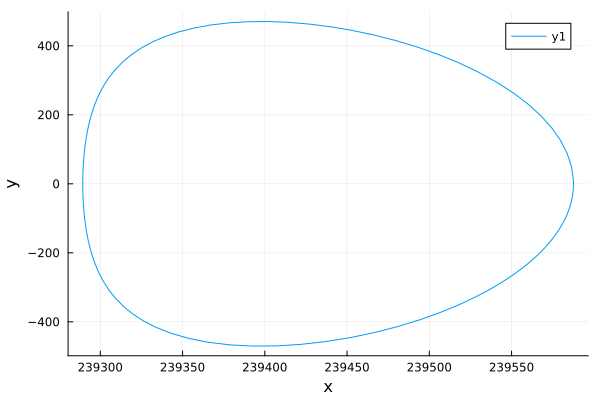

In [1349]:
#this is if we rollout our dynamics with the stable initial condition
#almost periodic, can be fixed with a differential corrector
#plot(all_state_in[1,:], all_state_in[2,:], all_state_in[3,:], xlabel="x", ylabel="y", zlabel="z")

plot(all_state_final[1,:], all_state_final[2,:], xlabel="x", ylabel="y")

In [1350]:
# #fix with a single shooting differential corrector
# function differential_corrector(x_0_stm, Tp)
    
#     #this is the final time it converges to
#     T_f = 0

#     #Iterate to bring the δx at T/2 to the desired state
#     max_iters = 1000

#     #keep z0 fixed and change only x0 and y_dot_0
#     for i=1:max_iters
#     #for i=1:100

#         solution = diff_solve(x_0_stm, Tp)

#         #this is the state, STM, and time when y crosses the XZ plane 
#         all_state, stm, sol_t = get_state_stm(solution)

#         #display(stm)

#         T2_state = all_state[:,end]

#         #T2_state -> x,y,z, xdot, ydot, zdot
#         #desired xdot an xzdot
#         xz_d = [0, 0]

#         rv = T2_state[1:6]

#         rv_dot = three_body_prob_dynamics_scaled(rv)

#         #desired state subtracted by state at t/2
#         δxz = xz_d - [T2_state[4], T2_state[6]]

#         #subset of the state transition matrix

#         #all 6 variables 
#         #stm_s = [stm[4,1] stm[4,3] stm[4,5]; stm[6,1] stm[6,3] stm[6,5]]

#         #to change x and ydot 

#         #keep z0 constant
#         #stm_s = [stm[4,1] stm[4,5]; stm[6,1] stm[6,5]]
#         #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,5]]

#         #keep x0 constant
#         stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
#         dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


#         #println("this is stm s: ")
#         #println(stm_s)


#         #keep y0 constant
#         #stm_s = [stm[4,1] stm[4,3]; stm[6,1] stm[6,3]]
#         #dy = [rv_dot[4]; rv_dot[6]]*[stm[2,1] stm[2,3]]

#         delta_x0 = (stm_s - dy/rv_dot[2])\δxz
        
#         #println("THIS IS CONDITION NUMBER")
#         #println(cond((stm_s - dy/rv_dot[2])))

#         #delta_x0 = stm_s\δxz

#         #update the initial state

#         #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
#         x_0_stm[3] = x_0_stm[3] + delta_x0[1]
#         x_0_stm[5] = x_0_stm[5] + delta_x0[2]

#         #x_0_stm[1:6] = x_0_stm[1:6] + delta
#         #when delta is below a set tolerance we are done

#         println("residual: ", δxz)
        
#         #loosen up the tolerance bc of the scaling of the problem
#         if norm(δxz) < 1e-6

#             #this is the total time, but we use it to ensure we have enough time to find where
#             #y crosses the xz plane
#             #print("this is sol t: ", sol_t)
#             #updating time
                    
#             T_f = sol_t[end]*2
#             break
#         end

#     end
    
#     corrected_solution = dynamics_integrate(x_0_stm, T_f)

#     all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
#     return all_state_final, stm_final, sol_t_final, corrected_solution
    
# end

In [1351]:
#run the differential corrector to get the corrected solution
# all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(x_0_stm, T_scaled)

In [1352]:
# all_state_final

In [1353]:
# sol_t_final

In [1354]:
# sol_t_final[end]/time_scale

In [1355]:
# all_state_final[1:3,1]/L 

In [1356]:
# all_state_final[4:6]/V_

In [1357]:
#Finding the unstable direction for the unstable manifold to encode as a constraint

#monodromy = stm_final[:,:,end]

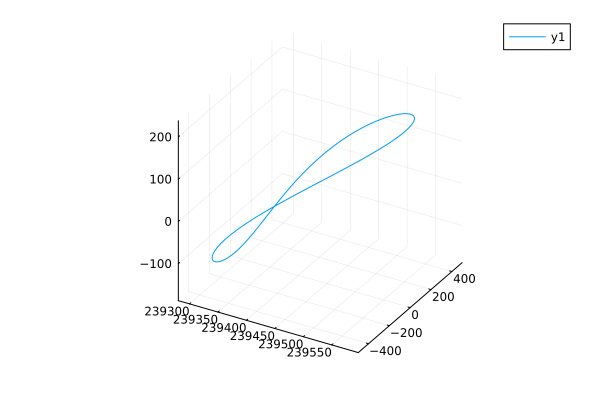

In [1358]:
plot(all_state_final[1,:], all_state_final[2,:], all_state_final[3,:])

In [1359]:
#using DelimitedFiles
#writedlm("xtraj.txt", all_state_final)

In [1360]:
final_norm = all_state_final[:,end] - all_state_final[:,1]

6-element Vector{Float64}:
 -1.2552482075989246e-7
  4.0833989522121697e-8
 -8.3632016867341e-9
 -1.2584086596075656e-6
  6.000091161695309e-7
 -2.103719554087034e-7

In [1361]:
#create a 2 orbit horizon reference trajectory
periodic_initial_condition2 = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic2 = [periodic_initial_condition2; Φ_0]

#integrate for 2 revs
solution_periodic2 = dynamics_integrate(x_0_periodic2, 2*sol_t_final[end])

all_state_2, stm_in_2, sol_t_in_2 = get_state_stm(solution_periodic2)

([239587.62743544072 239587.62736080837 … 239587.29102166792 239587.62724987674; 2.885776193752321e-15 -0.38997792038237183 … 26.167956189045622 6.0048346243489485e-5; … ; -4204.831491212667 -4204.830046806039 … -4198.322325069973 -4204.830603794723; -9.769906950017222e-10 -1.3222068144222896 … 88.7346509255946 -0.00031087389396341477], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000006080534125 -1.1566889707589837e-10 … 3.929490444623238e-8 3.4664461987515593e-12; -2.3619618074380635e-10 0.9999998186556232 … 9.274518981504611e-5 -1.371380294392567e-15; … ; -7.640163653361465e-6 -0.003910592108533885 … 0.9999994596348373 -5.914613949462251e-11; 0.002417980705284708 -4.443577812736203e-7 … 4.196736620558153e-12 0.9999997528014017;;; 1.0000019424487885 -6.604323020311631e-10 … 1.2552898374346295e-7 1.9792293104985152e-11; -1.34860465613969e-9 0.9999994206890758 … 0.00016576587923990675 -1.3995018960529636e-14; … ; -2.4406783277460395e-5 -0.006989

In [1362]:
#Check when the orbit leave
periodic_initial_condition = all_state_final[:,1]

#Integrate the dynamics with the perturbed initial condtition
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_periodic = [periodic_initial_condition; Φ_0]

#integrate for 3.5 revs
solution_periodic = dynamics_integrate(x_0_stm, 4*sol_t_final[end])

all_state_lp, stm_in_lp, sol_t_in_lp = get_state_stm(solution_periodic)

([239587.62743544072 239587.62736080837 … 239130.08609049686 239119.53871158187; 2.885776193752321e-15 -0.38997792038237183 … 112.93999595432864 108.13710849097018; … ; -4204.831491212667 -4204.830046806039 … -2633.838472503836 -2580.779139489224; -9.769906950017222e-10 -1.3222068144222896 … -1189.6696253115117 -1267.407936080102], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000006080534125 -1.1566889707589837e-10 … 3.929490444623238e-8 3.4664461987515593e-12; -2.3619618074380635e-10 0.9999998186556232 … 9.274518981504611e-5 -1.371380294392567e-15; … ; -7.640163653361465e-6 -0.003910592108533885 … 0.9999994596348373 -5.914613949462251e-11; 0.002417980705284708 -4.443577812736203e-7 … 4.196736620558153e-12 0.9999997528014017;;; 1.0000019424487885 -6.604323020311631e-10 … 1.2552898374346295e-7 1.9792293104985152e-11; -1.34860465613969e-9 0.9999994206890758 … 0.00016576587923990675 -1.3995018960529636e-14; … ; -2.4406783277460395e-5 -0.00698949844

In [1363]:
all_state_lp

6×415 Matrix{Float64}:
     2.39588e5        2.39588e5      2.39588e5  …      2.3913e5      2.3912e5
     2.88578e-15     -0.389978      -0.697018        112.94        108.137
   226.168          226.168        226.168           181.776       179.513
    -9.46749e-10     -1.60941       -2.87653       -5622.57      -5831.58
 -4204.83         -4204.83       -4204.83          -2633.84      -2580.78
    -9.76991e-10     -1.32221       -2.36321    …  -1189.67      -1267.41

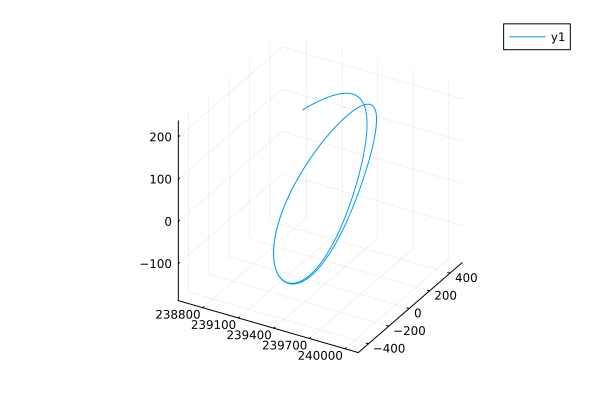

In [1364]:
plot(all_state_lp[1,:], all_state_lp[2,:], all_state_lp[3,:], aspectratio=true)

In [1365]:
#as seen above, after about 3.5 periods it begins to diverge from the periodic orbit 
#will formulate as a convex optimiztion problem to generate the station keeping 
#maneuvers

In [1366]:
#this is the continuous dynamics
#AL2 = ForwardDiff.jacobian(x-> three_body_prob_dynamics(x), all_state_final[:,1])

In [1367]:
#this is including the slack variable in the control vector
#B = [zeros(3,4); I][1:6, :]

In [1368]:
nx = 6 #number of states
nu = 3 #number of controls 

3

In [1369]:
sol_t_final[end ]

0.6752182741104091

In [1370]:
#this is the A tilde to get the discretized dynamics
#Ã = [AL2 B; zeros(4,10)]

#this is the number of knot points in one horizon
N_period = 41  #40 knot points per period per period

#N_h = 82 #horizon 2 periods

N_h = 81 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.01688045685276023

In [1371]:
sol_t_final[end]/time_scale

3.084590434258941

In [1372]:
all_state_final[:,1]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -9.467485007066476e-10
  -4204.831491212667
     -9.769906950017222e-10

In [1374]:
# custom_position_scale = norm(all_state_final[:,1])
# custom_time_scale = sol_t_final[end]
# custom_velocity_scale = custom_position_scale/custom_time_scale

In [1375]:
# function get_reference(i,N)
    
#     reference = zeros(nx, N)

#     for k=1:N

#         reference[:,k] = full_solution(horizon[i:end]).u[k][1:6]
        
#     end

#     return reference
    
# end

In [1376]:
#Ad = H[1:nx, 1:nx]
#Bd = H[1:nx, nx+1:end]

In [1377]:
#umin = 0.5
#umax = 1

In [1378]:
#N (number of knot points) 6x6 discrete dynamics jacobians

#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 41] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [1379]:
T_corrected = sol_t_final[end]

0.6752182741104091

In [1380]:
T_corrected*24 

16.20523857864982

In [1381]:
horizon = LinRange(0, T_corrected, N_period)

41-element LinRange{Float64, Int64}:
 0.0, 0.0168805, 0.0337609, 0.0506414, …, 0.641457, 0.658338, 0.675218

In [1382]:
horizon[2]

0.01688045685276023

In [1383]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 39] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 40] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [1384]:
horizon

41-element LinRange{Float64, Int64}:
 0.0, 0.0168805, 0.0337609, 0.0506414, …, 0.641457, 0.658338, 0.675218

In [1385]:
solution_final.u 

134-element Vector{Vector{Float64}}:
 [239587.62743544072, 2.885776193752321e-15, 226.1684428275936, -9.467485007066476e-10, -4204.831491212667, -9.769906950017222e-10, 1.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
 [239587.62736080837, -0.38997792038237183, 226.16838151341904, -1.6094060399205936, -4204.830046806039, -1.3222068144222896, 1.0000006080534125, -2.3619618074380635e-10, 1.1212805823473653e-7, 0.01311234168682283  …  9.730678815554506e-17, 0.0008473732147503594, 0.9999994596348373, 4.196736620558153e-12, 3.4664461987515593e-12, -1.371380294392567e-15, 9.274519887831095e-5, 1.1212803562238344e-7, -5.914613949462251e-11, 0.9999997528014017]
 [239587.627197025, -0.69701773530477, 226.16824695725015, -2.8765330345127236, -4204.826877003795, -2.363214991186429, 1.0000019424487885, -1.34860465613969e-9, 3.5819717257044353e-7, 0.02343603815913989  …  9.930224510915098e-16, 0.0015145322561489543, 0.9999982737840437, 2.396204352215592e-11, 1.97922931049851

In [1386]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = solution_final(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(solution_final(horizon).u[k][7:end], (6,6)) 
        
end

In [1387]:
#monodromy is the stm at the end of the periodic orbit
monodromy_eigen = eigen(stm_times[:,:,end])

stable_dir = real(monodromy_eigen.vectors[:,1])
unstable_dir = real(monodromy_eigen.vectors[:,end])
#find the eigen values of the monodromy

6-element Vector{Float64}:
 -0.08855910684745628
  0.02865744089746027
 -0.005939290756903623
 -0.8887776057645704
  0.4235137548994912
 -0.14836181248294958

In [1388]:
#save the unstable directions in a matrix
unstable_directions = zeros(6,N_period)

6×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [1389]:
#the unstable directions are then the stm at the timestep multiplied by the unstable direction found by the monodromy

for k = 1:N_period
    
    unstable_directions[:,k] = (stm_times[:,:,k]*unstable_dir)/norm(stm_times[:,:,k]*unstable_dir)
    
end

In [1390]:
#unstable directions for the unstable manifolds along the orbit
unstable_directions

6×41 Matrix{Float64}:
 -0.0885591   -0.0868902   -0.0851866   …  -0.0901749   -0.0885591
  0.0286574    0.0305544    0.0327074       0.0270383    0.0286574
 -0.00593929  -0.00723924  -0.00836188     -0.00446516  -0.00593929
 -0.888778    -0.869275    -0.847692       -0.906178    -0.888778
  0.423514     0.461042     0.499174        0.387077     0.423514
 -0.148362    -0.152531    -0.154425    …  -0.141881    -0.148362

In [1391]:
#[unstable_directions[1:3, 1]; zeros(3)]

In [1392]:
all_manifolds_plus = Matrix{Float64}[]
all_manifolds_minus = Matrix{Float64}[]

Matrix{Float64}[]

In [1393]:
dims_manifolds_plus = zeros(2, 41)
dims_manifolds_minus = zeros(2,41)

2×41 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

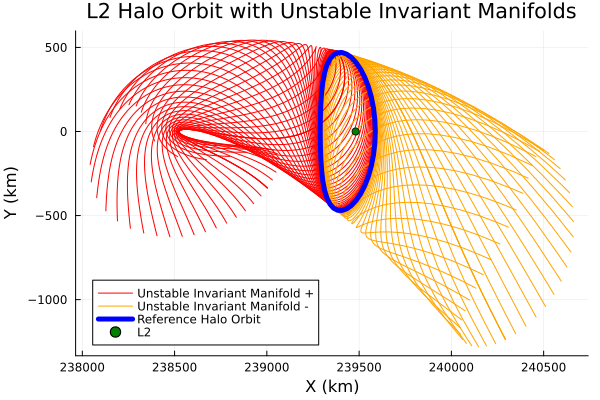

In [1394]:
#plot the manifolds
#+ manifold to the right
# - manifold to the left
epz = 3
#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit")

plot(reference_trajectory[1,:], reference_trajectory[2,:], label=nothing)

all_state_mplus = 0

all_state_mminus = 0
for i=1:41

    #initial_state = reference_trajectory[:,i] + epz.*unstable_directions[:,i]

    initial_state_plus = reference_trajectory[:,i] + epz.*[unstable_directions[1:3,i];zeros(3)]

    initial_state_minus = reference_trajectory[:,i] - epz.*[unstable_directions[1:3,i];zeros(3)]

    #initial_state = reference_trajectory[:,i] - epz.*unstable_directions[:,i]

    inv_manifold_plus = just_dynamics_integrate(initial_state_plus, 1.2*sol_t_final[end])

    inv_manifold_minus = just_dynamics_integrate(initial_state_minus, 1.25*sol_t_final[end])

    all_state_mplus = get_state(inv_manifold_plus)

    all_state_mminus = get_state(inv_manifold_minus)

    dims_manifolds_plus[1, i] = size(all_state_mplus)[1]
    dims_manifolds_plus[2, i] = size(all_state_mplus)[2]

    dims_manifolds_minus[1, i] = size(all_state_mminus)[1]
    dims_manifolds_minus[2, i] = size(all_state_mminus)[2]

    push!(all_manifolds_plus, all_state_mplus)
    push!(all_manifolds_minus, all_state_mminus)

    #plot!(all_state_m[1,:], all_state_m[2,:], all_state_m[3,:], color="red", legend=false)

    plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label=nothing)
    plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label=nothing)

end

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Orbit", linewidth = 5)


plot!(all_state_mplus[1,:], all_state_mplus[2,:], color="red", label = "Unstable Invariant Manifold +")
plot!(all_state_mminus[1,:], all_state_mminus[2,:], color="orange", label = "Unstable Invariant Manifold -")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], label="Reference Halo Orbit", linewidth = 5, xlabel = "X (km)", ylabel = "Y (km)", color="blue")
orbit_manifolds = scatter!([XL2[1]*L], [0], markercolor = "green", label = "L2", legend=true, title = "L2 Halo Orbit with Unstable Invariant Manifolds")

#savefig(orbit_manifolds, "enceladus_orbit_manifolds")

In [1395]:
# writedlm("enceladus_reference.txt", reference_trajectory, ',')
# writedlm("enceladus_manifold_plus.txt", all_manifolds_plus, ',')
# writedlm("enceladus_manifold_minus.txt", all_manifolds_minus, ',')

# writedlm("dims_enceladusmanifold_plus.txt", dims_manifolds_plus, ',')
# writedlm("dims_enceladusmanifold_minus.txt", dims_manifolds_minus, ',')

In [1396]:
XL2

6-element Vector{Float64}:
 1.00399194
 0.0
 0.0
 0.0
 0.0
 0.0

In [1397]:
XL2*L 

6-element Vector{Float64}:
 239481.19345626
      0.0
      0.0
      0.0
      0.0
      0.0

In [1398]:
#two orbits worth of data
unstable_constraint = cat(unstable_directions, unstable_directions, dims=2)

6×82 Matrix{Float64}:
 -0.0885591   -0.0868902   -0.0851866   …  -0.0901749   -0.0885591
  0.0286574    0.0305544    0.0327074       0.0270383    0.0286574
 -0.00593929  -0.00723924  -0.00836188     -0.00446516  -0.00593929
 -0.888778    -0.869275    -0.847692       -0.906178    -0.888778
  0.423514     0.461042     0.499174        0.387077     0.423514
 -0.148362    -0.152531    -0.154425    …  -0.141881    -0.148362

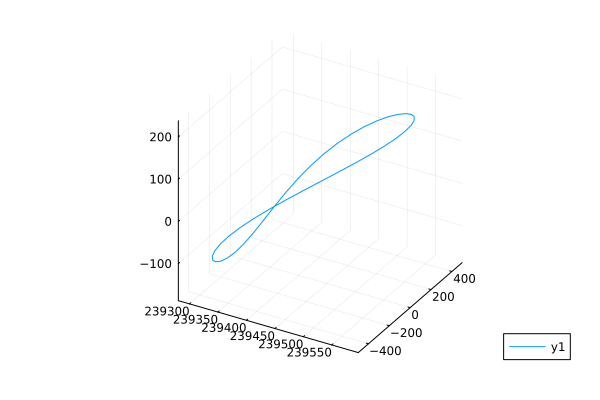

In [1399]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])
#scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])
#scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

In [1400]:
#obtain the reference trajectory at the knot points that we made up

#reference_trajectory = get_reference(1,N_period)

In [1401]:
#goal is to have a look ahead of 2 orbits and apply an MPC controller 

#3 periods worth of data (just using the same orbit over the 3 periods)
#reference_trajectory_all = [reference_trajectory reference_trajectory reference_trajectory]

In [1402]:
#inputs are in the custom scaled units

function three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)

    q_original = zeros(eltype(x),3)
    v_original = zeros(eltype(x),3)
    u_original = zeros(eltype(x),3)
    
    q_original = x[1:3]/L 
    v_original = x[4:6]/V_
    u_original = u/acceleration_scale
    
    x_original = [q_original; v_original; u_original]

    ẋ_original = zeros(eltype(x),9)

    #calculate the original xdot (no scaling)

    #xoriginal is in the CR3BP units
    ẋ_original = three_body_prob_dynamics_wcontrol(x_original)

    #then scale the output
    v_scaled = ẋ_original[1:3]*V_
    
    a_scaled = ẋ_original[4:6]*acceleration_scale

    u_scaled = ẋ_original[7:9]*acceleration_scale

    ẋ_scaled = [v_scaled; a_scaled]

    return ẋ_scaled

end

three_body_prob_dynamics_wcontrol_scaled_RK4 (generic function with 1 method)

In [1403]:
sol_t_final[end]

0.6752182741104091

In [1404]:
#RK4 integrator with a zero order hold

function RK4_integrator(x, u)

    f1 = three_body_prob_dynamics_wcontrol_scaled_RK4(x, u)
    f2 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f1, u)
    f3 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+0.5*Δt*f2, u)
    f4 = three_body_prob_dynamics_wcontrol_scaled_RK4(x+ Δt*f3, u)

    xnext = x + (Δt/6.0)*(f1+2*f2+2*f3+f4)

    return xnext

end



RK4_integrator (generic function with 1 method)

In [1405]:
reference_trajectory

6×41 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.7106           70.7106         4.0834e-8
   226.168          224.14            224.14         226.168
    -9.46749e-10   -291.102           291.102         -1.25936e-6
 -4204.83         -4157.08          -4157.08       -4204.83
    -9.76991e-10   -240.012      …    240.012         -2.11349e-7

In [1406]:
u0 = zeros(3)
Ak_rk4 = ForwardDiff.jacobian(x_-> RK4_integrator(x_, u0), reference_trajectory[:,1])

6×6 Matrix{Float64}:
  1.02015     -0.000696091   0.00370582  …  0.00129895   2.08271e-5
 -0.00142523   0.994037     -0.00027359     0.0167798   -1.50166e-6
  0.00371632  -8.25675e-5    0.991821       1.06492e-7   0.0168343
  2.38824     -0.12363       0.438051       0.153571     0.00369167
 -0.253504    -0.701248     -0.0485226      0.982132    -0.000355057
  0.440531    -0.0146564    -0.967874    …  2.59774e-5   0.991814

In [1407]:
Bk_rk4 = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,1], u_), u0)

6×3 Matrix{Float64}:
  0.000142671   7.31073e-6   8.8045e-8
 -7.33849e-6    0.00014205  -2.94841e-9
  8.8045e-8    -2.94841e-9   0.00014228
  0.0169269     0.0012973    2.07624e-5
 -0.00130714    0.0167798   -1.84432e-6
  2.08426e-5   -2.41156e-7   0.0168343

In [1408]:
for i=1:N_period

    #get the discrete dynamics jacobians for the entire reference trajectory along the knot points

    #Ak = ForwardDiff.jacobian(x-> three_body_prob_dynamics_scaled(x), reference_trajectory[:,i])
    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(x_, zeros(3)), reference_trajectory[:,i])

    #this is including the slack variable in the control vector (this is control on accelerations/thrust)
    #Bk = [zeros(3,3); I]

    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(reference_trajectory[:,i], u_), zeros(3))

    #this is the A tilde to get the discretized dynamics
    # Ãk = [Ak Bk; zeros(3,9)]

    # H = exp(Ãk*Δt)

    # all_Ad[:,:,i] = H[1:nx, 1:nx]

    # all_Bd[:,:,i] = H[1:nx, nx+1:end]
    
    
end

In [1409]:
all_Bd[:,:,1]

6×3 Matrix{Float64}:
  0.000142671   7.31073e-6   8.8045e-8
 -7.33849e-6    0.00014205  -2.94841e-9
  8.8045e-8    -2.94841e-9   0.00014228
  0.0169269     0.0012973    2.07624e-5
 -0.00130714    0.0167798   -1.84432e-6
  2.08426e-5   -2.41156e-7   0.0168343

In [1410]:
all_Ad[:,:,1] 

6×6 Matrix{Float64}:
  1.02015     -0.000696091   0.00370582  …  0.00129895   2.08271e-5
 -0.00142523   0.994037     -0.00027359     0.0167798   -1.50166e-6
  0.00371632  -8.25675e-5    0.991821       1.06492e-7   0.0168343
  2.38824     -0.12363       0.438051       0.153571     0.00369167
 -0.253504    -0.701248     -0.0485226      0.982132    -0.000355057
  0.440531    -0.0146564    -0.967874    …  2.59774e-5   0.991814

In [1411]:
all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.000142671   7.31073e-6   8.8045e-8
 -7.33849e-6    0.00014205  -2.94841e-9
  8.8045e-8    -2.94841e-9   0.00014228
  0.0169269     0.0012973    2.07624e-5
 -0.00130714    0.0167798   -1.84432e-6
  2.08426e-5   -2.41156e-7   0.0168343

[:, :, 2] =
  0.000142669   7.28339e-6    8.64853e-8
 -7.36584e-6    0.000142053  -8.64091e-9
  8.64853e-8   -8.64091e-9    0.000142279
  0.0169263     0.00129087    2.02514e-5
 -0.0013136     0.0167808    -3.15376e-6
  2.04337e-5   -1.58599e-6    0.016834

[:, :, 3] =
  0.000142665   7.2569e-6     8.34435e-8
 -7.39232e-6    0.000142059  -1.38034e-8
  8.34435e-8   -1.38034e-8    0.000142277
  0.0169252     0.00128467    1.94016e-5
 -0.00131984    0.0167824    -4.30514e-6
  1.96748e-5   -2.79927e-6    0.0168334

;;; … 

[:, :, 79] =
  0.000142669  7.36573e-6   8.64865e-8
 -7.28349e-6   0.000142053  8.61923e-9
  8.64865e-8   8.61923e-9   0.000142279
  0.0169266    0.00131038   2.06833e-5
 -0.00129407   0.0167802    

In [1412]:
#concatenate jacobians for two periods

# all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
# all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [1413]:
N_period

41

In [1414]:
num_revs = 10

10

In [1415]:
#1 revolution is 14 days
T*time_scale/60/60/24

7.815026320722327e-6

In [1416]:
T*time_scale

0.6752182741104091

In [1417]:
N_h

81

In [1418]:
#compute backward ricatti recursion

#cost to go matrices
#P = zeros((6,6,N_period*num_revs)) #size state x state (6x6) 
#K = zeros((3,6,N_period*num_revs)) #size control x state (3x6)

#cost to go matrices for 16 revs
P = zeros((6,6,N_period+((N_period-1)*15))) #size state x state (6x6) 
K = zeros((3,6,N_period+((N_period-1)*15))) #size control x state (3x6)

#this is working
# #state cost weight matrix
Q = 1.0*Matrix(I,6,6).*1e-6

#terminal cost weight matrix
Qf = 1.0*Matrix(I,6,6).*1e-6

#control cost weight matrix
R = 1.0*Matrix(I,3,3).*1e-3

3×3 Matrix{Float64}:
 0.001  0.0    0.0
 0.0    0.001  0.0
 0.0    0.0    0.001

In [1419]:
N_period+((N_period-1)*15)

641

In [1420]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 639] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 640] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0

In [1421]:
#1:(N_period*num_revs) - 1

In [1422]:
#all_Ad_rev = all_Ad

In [1423]:
all_Ad_16 = all_Ad
all_Bd_16 = all_Bd

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.000142671   7.31073e-6   8.8045e-8
 -7.33849e-6    0.00014205  -2.94841e-9
  8.8045e-8    -2.94841e-9   0.00014228
  0.0169269     0.0012973    2.07624e-5
 -0.00130714    0.0167798   -1.84432e-6
  2.08426e-5   -2.41156e-7   0.0168343

[:, :, 2] =
  0.000142669   7.28339e-6    8.64853e-8
 -7.36584e-6    0.000142053  -8.64091e-9
  8.64853e-8   -8.64091e-9    0.000142279
  0.0169263     0.00129087    2.02514e-5
 -0.0013136     0.0167808    -3.15376e-6
  2.04337e-5   -1.58599e-6    0.016834

[:, :, 3] =
  0.000142665   7.2569e-6     8.34435e-8
 -7.39232e-6    0.000142059  -1.38034e-8
  8.34435e-8   -1.38034e-8    0.000142277
  0.0169252     0.00128467    1.94016e-5
 -0.00131984    0.0167824    -4.30514e-6
  1.96748e-5   -2.79927e-6    0.0168334

;;; … 

[:, :, 39] =
  0.000142669  7.36573e-6   8.64865e-8
 -7.28349e-6   0.000142053  8.61923e-9
  8.64865e-8   8.61923e-9   0.000142279
  0.0169266    0.00131038   2.06833e-5
 -0.00129407   0.0167802    

In [1424]:
for i = 2:16
    all_Ad_16 = cat(all_Ad_16, all_Ad[:,:,2:end], dims = 3)
    all_Bd_16 = cat(all_Bd_16, all_Bd[:,:,2:end], dims = 3)
end


In [1425]:
# all_Ad_4 = cat(all_Ad_1, all_Ad_1, dims=3)
# all_Bd_4 = cat(all_Bd_1, all_Bd_1, dims=3)

# all_Ad_8 = cat(all_Ad_4, all_Ad_4, dims=3)
# all_Bd_8 = cat(all_Bd_4, all_Bd_4, dims=3)

# all_Ad_16 = cat(all_Ad_8, all_Ad_8, dims=3)
# all_Bd_16 = cat(all_Bd_8, all_Bd_8, dims=3)

In [1426]:
# for i = 1:num_revs
#     all_Ad_rev = (all_Ad_rev, all_Ad, dims=3)
# end

In [1427]:
# P[:,:,end] = Qf

# for k = reverse(1:(N_period*num_revs) - 1)
    
#     K[:,:,k] = (R + all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k])\(all_Bd_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:, k]) # ricatti recursion for both A and B matrices changing
#     P[:,:,k] = Q + all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Ad_1[:,:,k] - all_Ad_1[:,:,k]'*P[:,:,k+1]*all_Bd_1[:,:,k]*K[:,:,k]
 
# end 

In [1428]:
#Ricatti recursion over 2 periods
P[:,:,end] = Qf

for k = reverse(1:640)
    #println(k)    
    K[:,:,k] = (R + all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k])\(all_Bd_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:, k]) # ricatti recursion for both A and B matrices changing
    P[:,:,k] = Q + all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Ad_16[:,:,k] - all_Ad_16[:,:,k]'*P[:,:,k+1]*all_Bd_16[:,:,k]*K[:,:,k]
        
end

In [1429]:
P

6×6×641 Array{Float64, 3}:
[:, :, 1] =
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

[:, :, 2] =
 181.719     -68.8289    22.3521     14.2104      4.25664     0.707713
 -68.8289     26.0885    -8.47091    -5.38338    -1.60963    -0.265671
  22.3521     -8.47091    2.7617      1.7483      0.523048    0.0856493
  14.2104     -5.38338    1.7483      1.11148     0.332386    0.0549976
   4.25664    -1.60963    0.523048    0.332386    0.100926    0.0168392
   0.707713   -0.265671   0.0856493   0.0549976   0.0168392   0.00466386

[:, :, 3] =
 177.463     -74.5397    20.4156     14.0728      3.94232      0.437442
 -74.5397     31

In [1430]:
P[:,:,1]

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

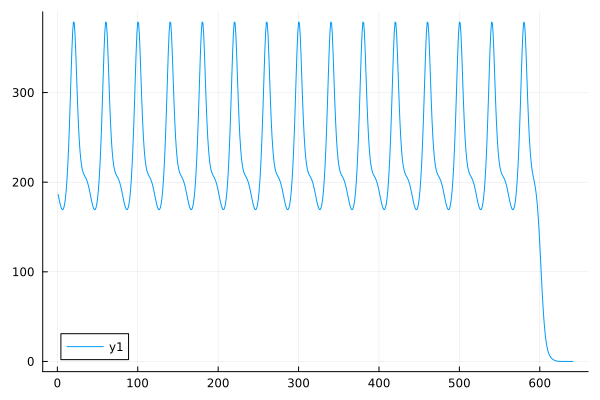

In [1431]:
plot(P[1,1,:])
#plot(P[2,2,:])
#plot(P[3,3,:])
#plot(P[4,4,:])
#plot(P[5,5,:])
#plot(P[6,6,:])

In [1432]:
#cost to go converges and is periodic! will get one orbit of the cost to go to make a constraint
V = P[:,:,1:41]

6×6×41 Array{Float64, 3}:
[:, :, 1] =
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

[:, :, 2] =
 181.719     -68.8289    22.3521     14.2104      4.25664     0.707713
 -68.8289     26.0885    -8.47091    -5.38338    -1.60963    -0.265671
  22.3521     -8.47091    2.7617      1.7483      0.523048    0.0856493
  14.2104     -5.38338    1.7483      1.11148     0.332386    0.0549976
   4.25664    -1.60963    0.523048    0.332386    0.100926    0.0168392
   0.707713   -0.265671   0.0856493   0.0549976   0.0168392   0.00466386

[:, :, 3] =
 177.463     -74.5397    20.4156     14.0728      3.94232      0.437442
 -74.5397     31.

In [1433]:
V[:,:,1]

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

In [1434]:
#cost to go matrices for 2 orbits worth of data
V_2orbits = cat(V, V[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

[:, :, 2] =
 181.719     -68.8289    22.3521     14.2104      4.25664     0.707713
 -68.8289     26.0885    -8.47091    -5.38338    -1.60963    -0.265671
  22.3521     -8.47091    2.7617      1.7483      0.523048    0.0856493
  14.2104     -5.38338    1.7483      1.11148     0.332386    0.0549976
   4.25664    -1.60963    0.523048    0.332386    0.100926    0.0168392
   0.707713   -0.265671   0.0856493   0.0549976   0.0168392   0.00466386

[:, :, 3] =
 177.463     -74.5397    20.4156     14.0728      3.94232      0.437442
 -74.5397     31.

In [1435]:
V_first = V_2orbits[:,:,1]

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

In [1436]:
V_first'

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

In [1437]:
difference = V_first - V_first'

6×6 Matrix{Float64}:
  0.0          -4.26326e-14   3.19744e-14  …  -9.76996e-15  -3.33067e-16
  4.26326e-14   0.0          -3.55271e-15     -4.44089e-16   1.17684e-14
 -3.19744e-14   3.55271e-15   0.0              2.22045e-16  -9.1871e-15
 -1.06581e-14  -8.88178e-16  -2.22045e-16     -5.55112e-16  -6.38378e-16
  9.76996e-15   4.44089e-16  -2.22045e-16      0.0           1.79023e-15
  3.33067e-16  -1.17684e-14   9.1871e-15   …  -1.79023e-15   0.0

In [1438]:
difference2 = V_2orbits[:,:,2] - V_2orbits[:,:,2]'

6×6 Matrix{Float64}:
  0.0          -5.68434e-14   2.84217e-14  …  -1.06581e-14   4.44089e-16
  5.68434e-14   0.0           7.10543e-15      4.44089e-16   1.30451e-14
 -2.84217e-14  -7.10543e-15   0.0             -1.44329e-15  -8.96505e-15
 -7.10543e-15  -1.77636e-15  -4.44089e-16     -5.55112e-16  -3.40006e-16
  1.06581e-14  -4.44089e-16   1.44329e-15      0.0           1.6584e-15
 -4.44089e-16  -1.30451e-14   8.96505e-15  …  -1.6584e-15    0.0

In [1439]:
symmetric_v1 = (V_first + V_first')/2

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

In [1440]:
#needed for the quadratic constraint
invsymmetricv1 = inv(symmetric_v1)

6×6 Matrix{Float64}:
   2404.9      792.918     156.99    …  -11457.6        -4039.53
    792.918    337.878      71.1663      -3722.86       -1334.9
    156.99      71.1663    101.31         -762.062       -142.552
 -24077.7    -7655.87    -1643.38            1.14756e5  40237.9
 -11457.6    -3722.86     -762.062       55305.3        19060.3
  -4039.53   -1334.9      -142.552   …   19060.3         7519.79

In [1441]:
invsymmetricv1 - invsymmetricv1'

6×6 Matrix{Float64}:
  0.0          -1.77283e-9    1.08827e-10  …  -6.8394e-10    6.22549e-10
  1.77283e-9    0.0           1.56589e-10     -8.66521e-9   -2.76418e-9
 -1.08827e-10  -1.56589e-10   0.0              4.79304e-10   2.23991e-10
  7.72343e-9    2.03072e-8   -5.60931e-10     -2.99187e-8   -1.91721e-8
  6.8394e-10    8.66521e-9   -4.79304e-10      0.0          -4.12183e-9
 -6.22549e-10   2.76418e-9   -2.23991e-10  …   4.12183e-9    0.0

In [1442]:
display(V_first)

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

In [1443]:
#far_deviation = [1, 0, 1, 0, 1, 0]

In [1444]:
#cost to go for this far deviation
#far_deviation'*inv(V_first)*far_deviation

In [1445]:
#get the initial delta x
#this is some noise on the reference trajectory

#some arbitrary deviation from the reference trajectory
#x_initial_ref = [1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5]

#this is working
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#this is working. Pretty far deviation in x = 385 km, and vy off by ~1e-3 km/s
#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]


#off by 385 km meters and ~1 mm/s

#x_initial_ref = [1e-3, 0, 0, 0, 1e-6, 0]


#try a small deviation
#works great with a small deviation
#x_initial_ref = [1e-9, 0, 0, 0, 1e-9, 0]

#trying a larger deviation
#these are in CR3BP units
x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]

x_initial_ref_scaled = [x_initial_ref[1:3]*L; x_initial_ref[4:6]*V_]

#ensure that the initial deviation is in the unstable manifold direction
#x_initial_ref = [1e-9, -1e-9, 1e-9, 1e-9, -1e-9, 1e-9]

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1446]:
reference_trajectory[1:3]/L  

3-element Vector{Float64}:
 1.0044381498075317
 1.209821947751561e-20
 0.0009481800654326879

In [1447]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1449]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1450]:
x_initial_ref_scaled[5]*(1e3/86400)

0.01261190715380955

In [1451]:
x_initial_ref_scaled'*V[:,:,1]*x_initial_ref_scaled

13.142367757534164

In [1452]:
V[:,:,20]

6×6 Matrix{Float64}:
 378.756    -37.573     -65.2223    17.4684    14.9217     -2.50088
 -37.573      3.74415     6.4725    -1.73132   -1.48221     0.246514
 -65.2223     6.4725     11.2756    -3.00939   -2.56994     0.426185
  17.4684    -1.73132    -3.00939    0.806      0.687762   -0.115262
  14.9217    -1.48221    -2.56994    0.687762   0.588623   -0.0982812
  -2.50088    0.246514    0.426185  -0.115262  -0.0982812   0.017459

In [1453]:
V[:,:,end]

6×6 Matrix{Float64}:
 186.217     -62.4026    24.0027    14.3337      4.63435     0.965085
 -62.4026     20.9248    -8.04937   -4.80379    -1.55187    -0.321539
  24.0027     -8.04937    3.11044    1.84834     0.596622    0.121337
  14.3337     -4.80379    1.84834    1.10359     0.356226    0.0739623
   4.63435    -1.55187    0.596622   0.356226    0.116385    0.0241916
   0.965085   -0.321539   0.121337   0.0739623   0.0241916   0.00668618

In [1454]:
test = eigen(V[:,:,20]).values

6-element Vector{Float64}:
   3.0327671665014525e-6
   0.00040276828914646737
   0.0006446740224288994
   0.017041802848350267
   0.043527344547849886
 395.1263598420219

In [1455]:
1/sqrt(test[6])

0.05030741455702749

In [1456]:
#concatenate unstable directions for 2 orbits

unstable_directions_2 = cat(unstable_directions, unstable_directions[:, 2:end], dims=2)

6×81 Matrix{Float64}:
 -0.0885591   -0.0868902   -0.0851866   …  -0.0901749   -0.0885591
  0.0286574    0.0305544    0.0327074       0.0270383    0.0286574
 -0.00593929  -0.00723924  -0.00836188     -0.00446516  -0.00593929
 -0.888778    -0.869275    -0.847692       -0.906178    -0.888778
  0.423514     0.461042     0.499174        0.387077     0.423514
 -0.148362    -0.152531    -0.154425    …  -0.141881    -0.148362

In [1457]:
# V_2orbits

In [1459]:
#works decent with 15 and 15
#these work good
# tube_pose_r = 1
# tube_vel_r = 20

tube_pose_r = 10
tube_vel_r = 10

10

In [1460]:
x_initial_ref[:,1]

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [1461]:
# c_test= unstable_directions[:,1]/tan(pi/6)

# manifold_constraint_test = norm(x_initial_ref[:,1]) - c_test'*(x_initial_ref[:,1])

In [1462]:
# dot(x_initial_ref[:,1], unstable_directions[:,1])

In [1463]:
# dot(reference_trajectory[:,1] + x_initial_ref, unstable_directions[:,1])

In [1464]:
# test = (reference_trajectory[:,1] + x_initial_ref)/norm(reference_trajectory[:,1] + x_initial_ref)

In [1465]:
# dot(test, unstable_directions[:,1])

In [1466]:
# L

In [1467]:
# dot(x_initial_ref, unstable_directions[:,1])

In [1468]:
all_Ad

6×6×41 Array{Float64, 3}:
[:, :, 1] =
  1.02015     -0.000696091   0.00370582  …  0.00129895   2.08271e-5
 -0.00142523   0.994037     -0.00027359     0.0167798   -1.50166e-6
  0.00371632  -8.25675e-5    0.991821       1.06492e-7   0.0168343
  2.38824     -0.12363       0.438051       0.153571     0.00369167
 -0.253504    -0.701248     -0.0485226      0.982132    -0.000355057
  0.440531    -0.0146564    -0.967874    …  2.59774e-5   0.991814

[:, :, 2] =
  1.02001     -0.00184642    0.00363856   …   0.00129248    2.04054e-5
 -0.00257715   0.99421      -0.000512787      0.0167806    -2.83883e-6
  0.00366136  -0.000324786   0.991786        -1.25917e-6    0.0168341
  2.3666      -0.259083      0.428088         0.152425      0.0036031
 -0.389269    -0.674627     -0.0763237        0.98229      -0.000588374
  0.432723    -0.0430699    -0.972867     …  -0.000214923   0.991765

[:, :, 3] =
  1.01979     -0.00295756    0.00350921   …   0.00128622    1.96374e-5
 -0.00369204   0.994509     -0.00072

In [1469]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.7106           70.7106         4.0834e-8
   226.168          224.14            224.14         226.168
    -9.46749e-10   -291.102           291.102         -1.25936e-6
 -4204.83         -4157.08          -4157.08       -4204.83
    -9.76991e-10   -240.012      …    240.012         -2.11349e-7

In [1470]:
reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×81 Matrix{Float64}:
    2.39289e5      2.3929e5     2.39292e5  …     2.3929e5     2.39289e5
    1.42845e-7    80.0752     157.408          -80.0752       1.42845e-7
 -175.727       -172.391     -162.594         -172.391     -175.727
   -3.71898e-6    86.1123     189.233          -86.1124      -3.71898e-6
 4771.28        4688.71      4448.96          4688.71      4771.28
    2.84507e-6   393.09       761.835      …  -393.09         2.84507e-6

In [1471]:
#get the reference trajectory when you are starting at the half


In [1472]:
#dynamics_wcontrol_integrate([reference_trajectory2[:,1]; zeros(3)], Δt).u[end][1:6]

In [1473]:
#cost to go level set
#works with 0.1

#THIS EPSILON IS WORKING
epsilon = 1

#works with 1e3
#epsilon = 1e3

umax = 0.025

0.025

In [1474]:
x_initial_ref'*P[:,:,1]*x_initial_ref

1.9560231108287192e-10

In [1475]:
P[:,:,end]

6×6 Matrix{Float64}:
 1.0e-6  0.0     0.0     0.0     0.0     0.0
 0.0     1.0e-6  0.0     0.0     0.0     0.0
 0.0     0.0     1.0e-6  0.0     0.0     0.0
 0.0     0.0     0.0     1.0e-6  0.0     0.0
 0.0     0.0     0.0     0.0     1.0e-6  0.0
 0.0     0.0     0.0     0.0     0.0     1.0e-6

In [1476]:
P[:,:,1]

6×6 Matrix{Float64}:
 186.218    -62.4036    24.003     14.3338      4.63412     0.9652
 -62.4036    20.9268    -8.0501    -4.80409    -1.55139    -0.321354
  24.003     -8.0501     3.11107    1.84845     0.596441    0.121278
  14.3338    -4.80409    1.84845    1.10364     0.356147    0.0739231
   4.63412   -1.55139    0.596441   0.356147    0.116508    0.0242578
   0.9652    -0.321354   0.121278   0.0739231   0.0242578   0.00683386

In [1477]:
#lower bound as 10 mm/s. Converting to an acceleration based off of our discretization as well as the units that we are using which 
#is km/day
lower_bound = 10/(Δt*86400)*(86400^2/1e6)

51.1834488566417

In [1478]:
# #10 mm/s
# Tmin = lower_bound
# #1 m/s
# Tmax = 100*lower_bound

In [1479]:
#formulate the problem at every solve


#pass in the initial condition, along with jacobians of the current reference trajectory 

#bias is a 6xN_h-1 matrix
function update_prob(x_initial_k, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, bias, reference_traj_k)
    
    #clear the constraints and decision variables every run
    #cons = 0
    #U = 0
    
    X = Variable(nx,N_h)
        
    U = Variable(nu, N_h-1)
    
    #initial state constraint
    cons = Constraint[X[:,1] == x_initial_k]

    #state constraints
    #Dynamics constraint (for the entire horizon)
    
    # for k=1:(N_h-1)
    #     #these are the dynamics for delta x
        
    #     #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        
    #     push!(cons, X[:,k+1] == all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k])
    # end


    #dynamics constraint with bias
    for k=1:(N_h-1)
        #these are the dynamics for delta x
        
        #all_Ad_k will have the 120 jacobians that are associated to the reference trajectory at the moment. 
        #check sign on the bias. parenthesis
        #push!(cons, zeros(6)== X[:,k+1] - all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k] - bias[:,k])
        
        #kinda working
        #push!(cons, zeros(6)== X[:,k+1] - (all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[:,k]) - bias[:,k])

        #Linear affine term in terms of Δx and Δu (the integrator is there because the reference trajectory is not dynamically feasible)
        #(x̄+Δx) - (f(x̄,ū) + AΔx + BΔu) - bias
        push!(cons, zeros(6)== reference_traj_k[:,k+1] + X[:,k+1] - (dynamics_wcontrol_integrate([reference_traj_k[:,k]; zeros(3)], Δt).u[end][1:6] + all_Ad_k[:,:,k]*X[:,k]+all_Bd_k[:,:,k]*U[1:3,k]) - bias[:,k])

        
        #in terms of x's
        #prob.constraints += X[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*(X[:,i] - X̄[i]) + B[i]*(U[:,i] - Ū[i])
        #in terms of deltas
        #prob.constraints += X̄[i+1] + ΔX[:,i+1] == rk4(model, dynamics, X̄[i], Ū[i], params.dt) + A[i]*ΔX[:,i] + B[i]*ΔU[:,i]


    end

    
    #already propagating the deltas since we are linearizing the dynamics about the reference trajectories
    
#     for k=1:(N_h-1)        
#         #Box constraints on the deviation from the reference trajectory
                
#         push!(cons, X[1,k] <= xmax)
#         push!(cons, X[1,k] >= -xmax)
#         push!(cons, X[2,k] <= ymax)
#         push!(cons, X[2,k] >= -ymax)
#         push!(cons, X[3,k]<= zmax)
#         push!(cons, X[3,k] >= -zmax)
         
#     end
    
    
    #tube constraint
    #for k=2:(N_h-1) #this was there before and works
    #THIS WORKS and gives nice impluses. removes the noise. HIGH tube pose r
    for k=1:N_h 
       push!(cons, norm(X[1:3,k],2) <= tube_pose_r)
    
       push!(cons, norm(X[4:6,k],2) <= tube_vel_r)
         
    end
    
    
    #cost to go constraint (Working, most current)
    # for k=2:N_h
        
    #    costtogo = P_k[:,:,k]
        
    #    costtogo_hermitian = (costtogo + costtogo')/2
        
    #    #relaxing bc of the manifold constraint
    #    ctg_constraint = quadform(X[:,k], costtogo_hermitian) <= epsilon
        
    #    push!(cons, ctg_constraint)
                
    # end
    
    #manifold constraint (useful)
    #the delta x needs to be normalized
    #exits to the left with the negative sending
    #this is what is used. for some reason it is being infeasbile in problem 2
   #for k=1:N_h
#     for k=2:N_h 
        
#       #this works the best. investigate why 
#       #manifold goes to the left.  (w no ctg constraint)
#       #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.5*norm(X[:,k]))
        
        
#       #testing  (working) 
#       #goes left with positive unstable direction
#       manifold_constraint = dot(X[:,k], 1*unstable_directions_k[:,k])
        
#       #push!(cons, manifold_constraint >= 0.1*norm(X[:,k]))

#       #push!(cons, manifold_constraint >= 0)

#       #trying out 
#       push!(cons, manifold_constraint > 0)

                
        
#    end



#this is working
for k = 2:N_h
#to have this at 1, the initial deviation has to satisfy this constraint off the bat. 
#for k = 1:N_h
            
    #manifold goes to the right
    #manifold_constraint = dot(X[:,k], unstable_directions_k[:,k])
    manifold_constraint = X[:,k]'*-unstable_directions_k[:,k]
    
    #currently working
    #push!(cons, manifold_constraint > 0)

    #add some slack (works with the positive stable directions. negative stable directions still some that don't satisfy fully)
    #push!(cons, manifold_constraint > 1e-6)

    #will try bumping up the slack (tried 1e-5, worked better but not 100%)
    #1e-4 works good 
    #works good 1e-3
    #works with 1e-1 but at a higher cost

    #this was final but it was not great
    push!(cons, manifold_constraint > 5e-2)

    #does not provide impulses
    #push!(cons, manifold_constraint > 1)

    
end




   #manifold glideslope constraint for the whole unstable direction

#    for k=2:N_h
#     for k=1:N_h

#         #works with pi/5 too
#         c = unstable_directions_k[:,k]/tan(pi/6)

#         manifold_constraint = norm(X[:,k]) - c'*(X[:,k])

#         push!(cons, manifold_constraint <= 0)

#    end

#currently the one being used
# for k=2:N_h
        
#     #works with pi/5 too
#     c = unstable_directions_k[:,k]/tan(pi/6)
#     #c = unstable_directions_k[:,k]/tan((pi/2) - deg2rad(60)

#     manifold_constraint = norm(X[:,k]) - c'*X[:,k]

#     push!(cons, manifold_constraint <= 0)

# end

    
     
    #Controls Constraint
    #convexification constraint

    # for k=1:(N_h-1)

    #     push!(cons, Tmin <= U[1,k])
    #     push!(cons, Tmin <= U[2,k])
    #     push!(cons, Tmin <= U[3,k])

    # end
    
    #not working
    # for k=1:(N_h-1)

    #     σ1 = U[4,k]

    #     push!(cons, Tmin <= σ1)

    #     push!(cons, norm(U[1:3, k]) <= min(σ1, Tmax))

    # end
        
    #    push!(cons, U[1:3, k]> umin)
        
        
        #not working
        #σ = U[4,k]
        
        #convexified non convex constraint lower bound
        #push!(cons, umin <= σ)
        
        #convexified non convex constraint upper bound
        #push!(cons, σ <= umax)
        
        #convex upper bound on the thrust norm
        #push!(cons, norm(U[1:3,k]) <= σ)
        
        
        #upper bound
        #push!(cons, norm(U[1:3,k]) <= min(σ, umax))
        
        
    #end

    
    #print("done")
    
    return cons, X, U
        
end

update_prob (generic function with 1 method)

In [1480]:
1e-6*86400^2/1e3

7.46496

In [1481]:
unstable_directions[:,1]

6-element Vector{Float64}:
 -0.08855910684745628
  0.02865744089746027
 -0.005939290756903623
 -0.8887776057645704
  0.4235137548994912
 -0.14836181248294958

In [1482]:
#create the optimization problem

function solve_opt(cons, X, U, N)
    
    #these are tuning parameters
    
    #controls how tight you are tracking the reference 
    #α = 1e3
    
    #controls how much control effort you want to use (high value = low control)
    #β = 1e6
    #β = [1e6, 1e6, 1e15]
    #β = [1e3, 1e3, 1e3]
    #works with 1
    #works good with 1e-4 on just tracking and 0 on controls
    #β = 0
    #α = 1e-5

    #testing
    β = 1e6
    α = 1

    
    #β = 1 #some of the revs are slow to solve and solution may be innacurate
    
    #the cost function (L1 norm on the cost and the tracking error)
    obj = 0
    
    #for k=1:N
    #    obj += α*norm(X[:,k], 1)
    #end
    
    
    #for a lyaponov orbit we want to stay in the x y plane, so we penalize z maneuvers heavily while 
    #allowing for x and y
    
    for k=1:N-1
        
       #obj += β[1]*abs(U[1,k])+β[2]*abs(U[2,k]) +β[3]*abs(U[3,k])  
        
       #obj += β*norm(U[:,k], 1)
        
        #use L2 norm
        
        #^2 doesn't work in Convex.jl. have to use quadform 
        #obj += β*(norm(U[:,k]))^2 + α*(norm(X[:,k]))^2

        #obj = (norm(X[:,k]))^2

        
        #Px = 1.0*Matrix(I,6,6)

        #Pu = 1.0*Matrix(I,3,3)  
        #this gives the expected behavior with the manifolds but it does not minimize for cost
        #obj += quadform(X[:,k], Px; assume_psd=false)

        #obj += quadform(U[:,k], Pu; assume_psd=false)
        
        #this cost function works good, but gives continous thrust 
        #obj += quadform(U[:,k], Pu; assume_psd=false) + quadform(X[:,k], Px; assume_psd=false)
        #obj += β*norm(U[:,k], 1) + α*norm(X[:,k], 1)


        #this objective works well and gives impulsive thrust that bias the trajectory in a way for a safe escape left/right
        #obj += norm(U[:,k], 1) + 1e-2*norm(X[:,k], 1) 

        obj += norm(U[:,k], 1)

        
    end
            
    
    prob = minimize(obj, cons);
    
    #this objective function is working
    #prob = minimize(norm(X[:,end]), cons);
    
    #this works too
    #prob = minimize(quadform(X[:,end], Q), cons)
    #this solver options does not work...
    #solver_opts = MosekSolverOptions(LOG=0, MSK_IPAR_INTPNT_CO_TOL_REL_GAP=1e-6)  # Adjust tolerance here
    #print("mosek solving")
    #solve the problem with Mosek
    Convex.solve!(prob, ()-> Mosek.Optimizer(), silent_solver= true);
    
    #solve the problem with ECOS
    #Convex.solve!(prob, ()-> ECOS.Optimizer(), silent_solver=false);
    
    Xm = X.value;
    Um = U.value;

    #display(prob.status)
    
    return Xm, Um
    
end

solve_opt (generic function with 1 method)

In [1483]:
#Q = Matrix(I,6,6).*[1e7*ones(3); 1e7*ones(3)]

#the manifold constraint is the one that is not being satisfied. I think it has to do with numerical conditioning as the values are very small


In [1484]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1485]:
reference_trajectory[:,1] - reference_trajectory[:,end]

6-element Vector{Float64}:
  1.2552482075989246e-7
 -4.0833989522121697e-8
  8.3632016867341e-9
  1.2584086596075656e-6
 -6.000091161695309e-7
  2.103719554087034e-7

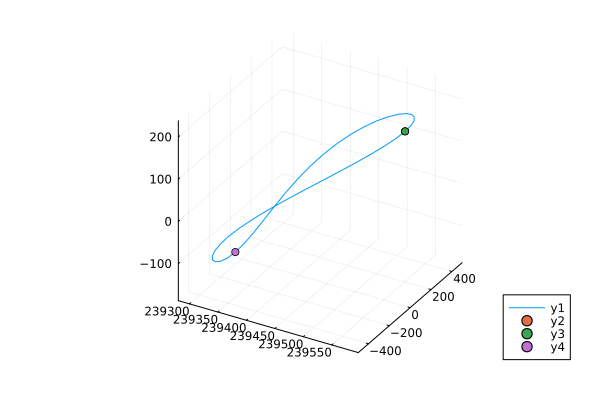

In [1486]:
plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

scatter!([reference_trajectory[1,end]], [reference_trajectory[2,end]], [reference_trajectory[3,end]])

scatter!([reference_trajectory[1,21]], [reference_trajectory[2,21]], [reference_trajectory[3,21]])


#plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:])

In [1487]:
x_initial_ref

6-element Vector{Float64}:
 1.0e-6
 0.0
 0.0
 0.0
 1.0e-6
 0.0

In [1488]:
#reference_traj_1 = [reference_trajectory reference_trajectory]

In [1489]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1490]:
N_h

81

In [1491]:
#just test to see if it solves

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)
bias_0 = zeros(6, N_h-1)

#there was nothing in place for all_Ad_1, maybe a bug? 
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, bias_0, reference_trajectory2)
display("solving")
display(X)
Xm, Um = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 153…410

([0.238529 0.24440058373105458 … 0.5494518626671674 0.6333928621072696; 0.0 0.017963013745849705 … 0.013799497703320757 -0.04624452303516894; … ; 1.0896687780891452 1.0126070258163264 … -3.2022604333248488 -3.9281824565480568; 0.0 5.496728174880648 … 6.648799071722806 7.532531678269505], [-2.6527557463406257 -63.18588160154072 … -2.7325287419231844e-11 -2.387153654915673e-11; -1.8504979302366262e-9 -2.98990120372107e-9 … 1.0770133267455588e-11 1.465367189728245e-11; 320.279777339083 81.01073641584544 … -3.121014629021699e-11 -3.1187111037768696e-11])

In [1492]:
norm(x_initial_ref_scaled[1:3]) 

0.238529

In [1493]:
Um

3×80 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -2.73253e-11  -2.38715e-11
  -1.8505e-9   -2.9899e-9   -7.15413e-9      1.07701e-11   1.46537e-11
 320.28        81.0107       2.71165e-8     -3.12101e-11  -3.11871e-11

In [1495]:
#check the constraint

#this is because the constraint is from 2:Nh
constraint_satisfied = zeros(N_h)

for i=1:N_h
    constraint_satisfied[i] = dot(Xm[:,i], unstable_directions_2[:,i])
end

#constraint is not being satisfied... has to do with the cost function. whenever I have a
#tracking cost with a weight of 1e-2 and a control cost with scale 1, it doesn't work. However, 
#when I remove the cost on the controls and make the weight less on the tracking (1e-5) it works (up to the last point)

#with just a tracking cost with a weight of 1e-2 it doesn't satisfy the constraint fully

In [1496]:
constraint_satisfied[1]

0.4403658006080574

In [1497]:
constraint_satisfied[15]

-0.9999999998918274

In [1498]:
Xm[:,18]/norm(Xm[:,18])

6-element Vector{Float64}:
  0.005684694111808674
 -0.04687955576275817
  0.08803521470184258
 -0.07701161848742759
 -0.0977005165303384
 -0.987189754892338

In [1499]:
unstable_directions[:,18]

6-element Vector{Float64}:
 -0.05611656615718857
  0.05989976510205948
 -0.000647465149060984
 -0.6938166224217691
  0.7046364418759312
  0.12396979133643968

In [1500]:
constraint_satisfied[60:70]

11-element Vector{Float64}:
 -1.0001700562975553
 -0.9999999998861641
 -1.0092650013207667
 -1.0243723241585239
 -1.043389562937223
 -1.0672372949309876
 -1.1013251084547422
 -1.1549413119514003
 -1.2391495154053416
 -1.3635222214387392
 -1.5347733343616414

In [1501]:
constraint_satisfied

81-element Vector{Float64}:
  0.4403658006080574
 -0.9999999998910551
 -0.9999999998910002
 -0.999999999891013
 -0.9999999998907607
 -0.9999999998903056
 -0.9999999998908313
 -0.9999999998890935
 -0.9999999998902951
 -0.9999999998881608
  ⋮
 -2.357315042226599
 -2.73532394627753
 -3.1674033246894964
 -3.658585485842943
 -4.218722942020375
 -4.86230795256544
 -5.609598815179879
 -6.486344348315004
 -7.5238398964716415

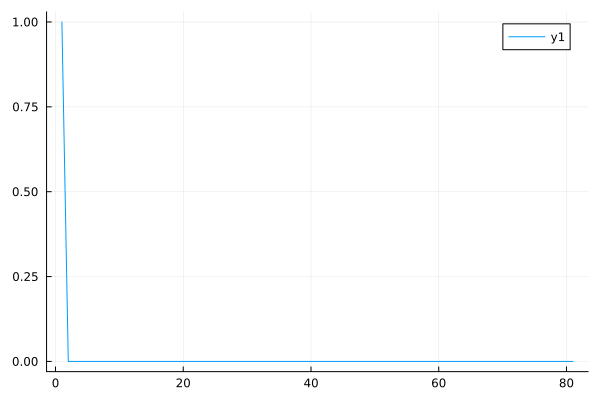

In [1502]:
constraint_bool = constraint_satisfied .> 0

plot(constraint_bool)

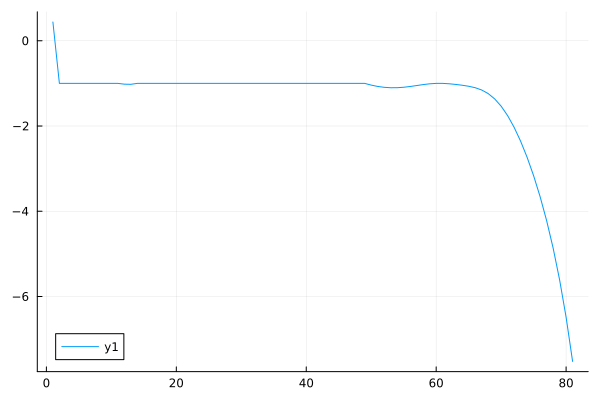

In [1503]:
plot(constraint_satisfied)

In [1504]:
constraint_satisfied

81-element Vector{Float64}:
  0.4403658006080574
 -0.9999999998910551
 -0.9999999998910002
 -0.999999999891013
 -0.9999999998907607
 -0.9999999998903056
 -0.9999999998908313
 -0.9999999998890935
 -0.9999999998902951
 -0.9999999998881608
  ⋮
 -2.357315042226599
 -2.73532394627753
 -3.1674033246894964
 -3.658585485842943
 -4.218722942020375
 -4.86230795256544
 -5.609598815179879
 -6.486344348315004
 -7.5238398964716415

In [1505]:
constraint_bool[44]

false

In [1506]:
Xm 

6×81 Matrix{Float64}:
 0.238529  0.244401   0.253669   …   0.474114    0.549452    0.633393
 0.0       0.017963   0.0337295      0.0623262   0.0137995  -0.0462445
 0.0       0.0464558  0.15103       -0.806127   -0.701887   -0.582097
 0.0       0.698754   0.404374       4.24529     4.69824     5.27545
 1.08967   1.01261    0.854178      -2.55831    -3.20226    -3.92818
 0.0       5.49673    6.87602    …   5.68929     6.6488      7.53253

In [1507]:
residual = zeros(6, N_h-1)

6×80 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [1508]:
reference_trajectory[:,1]

6-element Vector{Float64}:
 239587.62743544072
      2.885776193752321e-15
    226.1684428275936
     -9.467485007066476e-10
  -4204.831491212667
     -9.769906950017222e-10

In [1509]:
reference_trajectory[:,end]

6-element Vector{Float64}:
 239587.6274353152
      4.083399240789789e-8
    226.1684428192304
     -1.2593554081082722e-6
  -4204.831490612658
     -2.1134894610370511e-7

In [1510]:
input = [Xm[:,1] + reference_trajectory[:,1]; Um[:,1]]

9-element Vector{Float64}:
 239587.86596444072
      2.885776193752321e-15
    226.1684428275936
     -9.467485007066476e-10
  -4203.741822434578
     -9.769906950017222e-10
     -2.6527557463406257
     -1.8504979302366262e-9
    320.279777339083

In [1511]:
#reference_trajectory2 = [reference_trajectory reference_trajectory]

In [1512]:
#find the residual

for k = 1:N_h-1

    input = [Xm[:,k] + reference_trajectory2[:,k]; Um[:,k]]

    xnext_sol = dynamics_wcontrol_integrate(input, Δt)

    residual[:,k] = reference_trajectory2[:,k+1] + Xm[:,k+1] - xnext_sol.u[end][1:6]

end

In [1513]:
residual

6×80 Matrix{Float64}:
  9.45467e-7    9.9797e-7     1.06989e-6   …  -5.6843e-6    -3.52279e-6
  9.80284e-7   -3.18341e-7   -8.00117e-7       1.35264e-7    6.58314e-7
  2.30593e-7   -1.48251e-7   -7.1233e-7        3.55856e-6    4.67702e-6
  0.000109367   0.000126824   0.000130911     -0.000581061  -0.000302204
 -2.02064e-5   -4.81761e-5   -7.88552e-5       1.15344e-6    5.16319e-5
  1.21865e-5   -3.76233e-6   -6.1865e-5    …   0.00047268    0.000607515

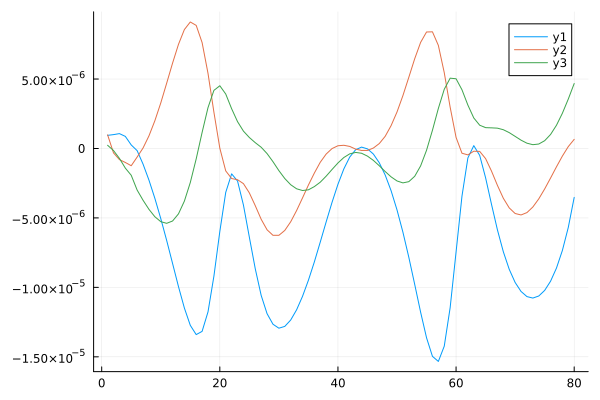

In [1514]:
plot(residual[1,:])
plot!(residual[2,:])
plot!(residual[3,:])

In [1515]:
#for one period 40 controls
xtraj_test = integrate_oneperiod(Xm[:,1] + reference_trajectory[:,1], Um[:,1:40])

6×41 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7439         0.0214185
   226.168          224.186           223.537        225.7
    -9.46749e-10   -290.403           291.251          0.0698546
 -4203.74         -4156.07          -4157.77       -4205.55
    -9.76991e-10   -234.515      …    247.682          8.25714

In [1516]:
# Xm[:,1]

In [1517]:
delta_test = xtraj_test - reference_trajectory

6×41 Matrix{Float64}:
 0.238529  0.2444     0.253665   …   0.14453     0.148099    0.149833
 0.0       0.017962   0.0337294      0.0445155   0.0333466   0.0214185
 0.0       0.0464555  0.151029      -0.726433   -0.602808   -0.468205
 0.0       0.698645   0.404138       0.27947     0.149229    0.0698558
 1.08967   1.01263    0.854265      -0.629861   -0.68837    -0.721408
 0.0       5.49672    6.87601    …   6.95574     7.67044     8.25714

In [1518]:
# dot(delta_test[:,1], unstable_directions[:,1])

In [1519]:
# delta_test - Xm[:,1:41]

In [1520]:
# xtraj_test[:,1] - reference_trajectory[:,1]

In [1521]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1522]:
# delta_test[:,1]

In [1523]:
Xm[:,1]

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1524]:
constraint_satisfied_ndynamics = zeros(41)

for i=1:41
    constraint_satisfied_ndynamics[i] = dot(delta_test[:,i], unstable_directions[:,i])
end

In [1525]:
# delta_test[:,21]

In [1526]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  0.44036580060833785
 -0.9998937014720303
 -0.9997551343889834
 -0.9995973999283893
 -0.9994521850361142
 -0.9993728058744273
 -0.9993734189075794
 -0.9995062435253952
 -0.999802136341182
 -1.0002927667407275
  ⋮
 -1.141250780479477
 -1.1680836136399046
 -1.2004913001677435
 -1.2397072112979701
 -1.287236981310456
 -1.3448985691123805
 -1.4148701618905084
 -1.4997339601443374
 -1.6025307614218822

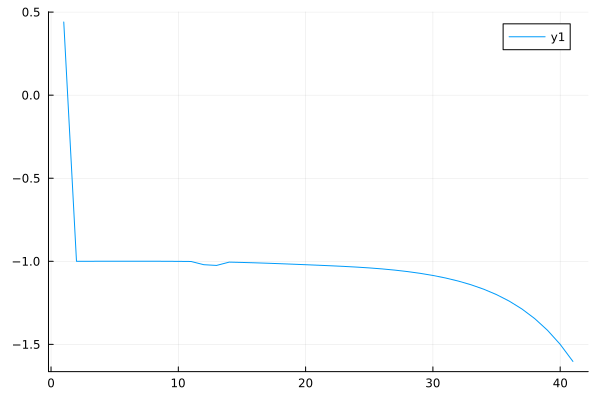

In [1527]:
plot(constraint_satisfied_ndynamics)

In [1528]:
constraint_satisfied

81-element Vector{Float64}:
  0.4403658006080574
 -0.9999999998910551
 -0.9999999998910002
 -0.999999999891013
 -0.9999999998907607
 -0.9999999998903056
 -0.9999999998908313
 -0.9999999998890935
 -0.9999999998902951
 -0.9999999998881608
  ⋮
 -2.357315042226599
 -2.73532394627753
 -3.1674033246894964
 -3.658585485842943
 -4.218722942020375
 -4.86230795256544
 -5.609598815179879
 -6.486344348315004
 -7.5238398964716415

In [1529]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  0.44036580060833785
 -0.9998937014720303
 -0.9997551343889834
 -0.9995973999283893
 -0.9994521850361142
 -0.9993728058744273
 -0.9993734189075794
 -0.9995062435253952
 -0.999802136341182
 -1.0002927667407275
  ⋮
 -1.141250780479477
 -1.1680836136399046
 -1.2004913001677435
 -1.2397072112979701
 -1.287236981310456
 -1.3448985691123805
 -1.4148701618905084
 -1.4997339601443374
 -1.6025307614218822

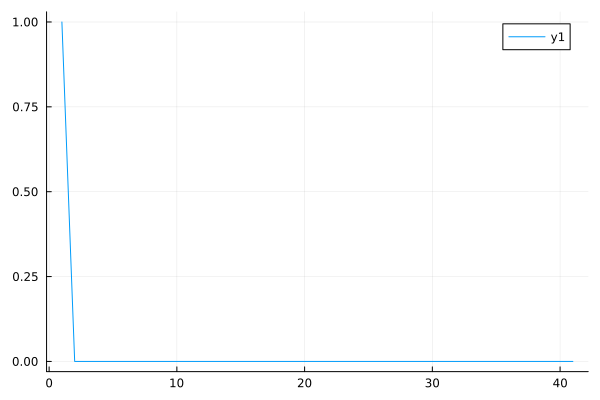

In [1530]:
plot(constraint_satisfied_ndynamics .>0)

In [1531]:
constraint_satisfied_ndynamics

41-element Vector{Float64}:
  0.44036580060833785
 -0.9998937014720303
 -0.9997551343889834
 -0.9995973999283893
 -0.9994521850361142
 -0.9993728058744273
 -0.9993734189075794
 -0.9995062435253952
 -0.999802136341182
 -1.0002927667407275
  ⋮
 -1.141250780479477
 -1.1680836136399046
 -1.2004913001677435
 -1.2397072112979701
 -1.287236981310456
 -1.3448985691123805
 -1.4148701618905084
 -1.4997339601443374
 -1.6025307614218822

In [1532]:
final = Xm + [reference_trajectory reference_trajectory[:,2:end]]

6×81 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39586e5      2.39588e5
     2.88578e-15    -70.6926           70.7244        -0.0462445
   226.168          224.186           223.438        225.586
    -9.46749e-10   -290.403           295.8            5.27545
 -4203.74         -4156.07          -4160.28       -4208.76
    -9.76991e-10   -234.515      …    246.66           7.53253

In [1533]:
residual

6×80 Matrix{Float64}:
  9.45467e-7    9.9797e-7     1.06989e-6   …  -5.6843e-6    -3.52279e-6
  9.80284e-7   -3.18341e-7   -8.00117e-7       1.35264e-7    6.58314e-7
  2.30593e-7   -1.48251e-7   -7.1233e-7        3.55856e-6    4.67702e-6
  0.000109367   0.000126824   0.000130911     -0.000581061  -0.000302204
 -2.02064e-5   -4.81761e-5   -7.88552e-5       1.15344e-6    5.16319e-5
  1.21865e-5   -3.76233e-6   -6.1865e-5    …   0.00047268    0.000607515

In [1534]:
#test out the integration function
#xtraj_test = integrate_oneperiod(final[:,1], Um[:,1:39])

In [1535]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

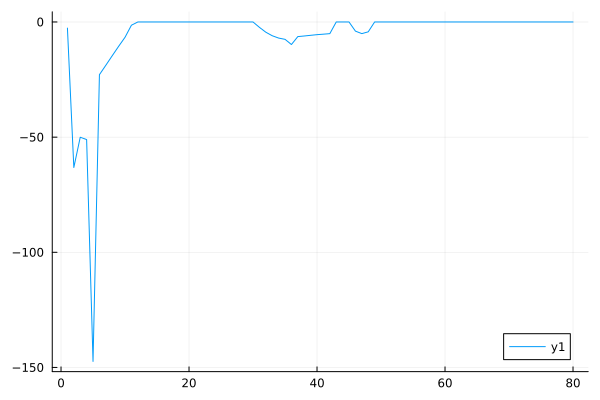

In [1536]:
plot(Um[1,:])

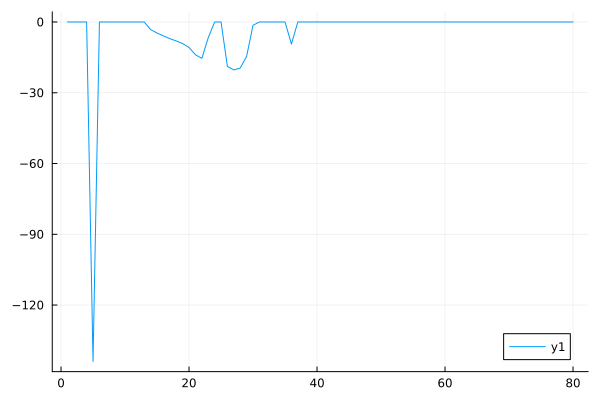

In [1537]:
plot(Um[2,:])

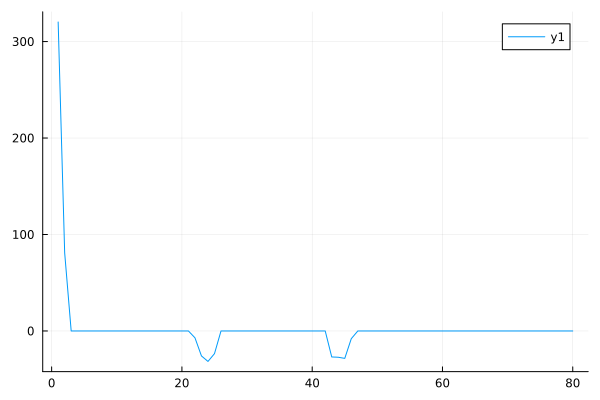

In [1538]:
plot(Um[3,:])

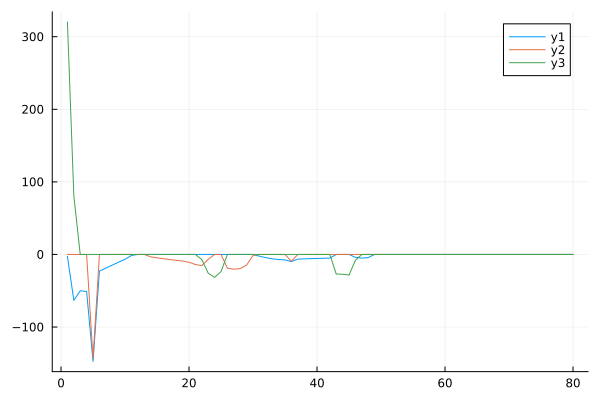

In [1539]:
plot(Um[1,:])
plot!(Um[2,:])
plot!(Um[3,:])

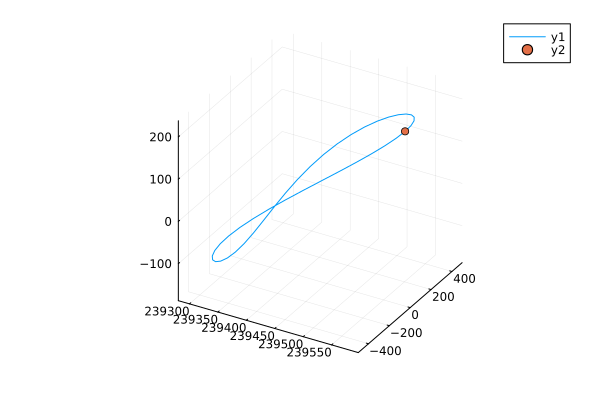

In [1540]:
#check out the 1 period solve

#the x trajectory is generated using the linear dynamics
plot(final[1,1:41], final[2,1:41], final[3,1:41])
scatter!([final[1,1]], [final[2,1]], [final[3,1]])

In [1541]:
#plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [1542]:
#xtraj_test - reference_trajectory

In [1543]:
#unstable_directions[:,2]

In [1544]:
#norm(xtraj_test[:,41] - xtraj_test[:,1])

In [1545]:
residual

6×80 Matrix{Float64}:
  9.45467e-7    9.9797e-7     1.06989e-6   …  -5.6843e-6    -3.52279e-6
  9.80284e-7   -3.18341e-7   -8.00117e-7       1.35264e-7    6.58314e-7
  2.30593e-7   -1.48251e-7   -7.1233e-7        3.55856e-6    4.67702e-6
  0.000109367   0.000126824   0.000130911     -0.000581061  -0.000302204
 -2.02064e-5   -4.81761e-5   -7.88552e-5       1.15344e-6    5.16319e-5
  1.21865e-5   -3.76233e-6   -6.1865e-5    …   0.00047268    0.000607515

In [1546]:
#solve the problem again and pass in the residual as the bias in the dynamics constraint
display("updating prob")
cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_1, all_Bd_1, V_2orbits, unstable_directions_2, residual, reference_trajectory2)
display("solving")
display(X)
Xm2, Um2 = solve_opt(cons, X, U, N_h)

"updating prob"

"solving"

Variable
size: (6, 81)
sign: real
vexity: affine
id: 154…721

([0.238529 0.24427176794914832 … 0.5495896516828307 0.6334871409603913; 0.0 0.017970676962247776 … 0.01360950438737605 -0.04637868321773522; … ; 1.0896687780891452 1.0137701124007674 … -3.199254878346482 -3.9246323460936514; 0.0 5.587080972019797 … 6.6517924405790465 7.5359426007249], [-3.5655812607136164 -62.240065545218 … -6.277540485820911e-11 -5.456044511760821e-11; -4.40925721380382e-9 -6.888368881129444e-9 … 2.435990259380187e-11 3.325388505930622e-11; 325.647378454007 75.7695224123518 … -7.117827341677989e-11 -7.080624709985582e-11])

In [1547]:
half_rev_control = Um2[1:3, 1:21]/acceleration_scale

3×21 Matrix{Float64}:
 -7.16279e-7   -1.25032e-5   -1.00574e-5  …   1.4126e-15    1.14608e-15
 -8.85763e-16  -1.38378e-15  -3.2899e-15     -2.17034e-6   -2.79291e-6
  6.54184e-5    1.52211e-5    1.2809e-14      8.60974e-17   1.27386e-16

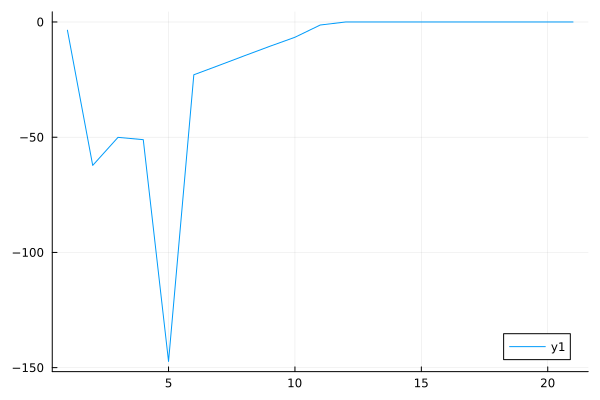

In [1549]:
plot(Um2[1,1:21])

In [1550]:
Um2[:,1]

3-element Vector{Float64}:
  -3.5655812607136164
  -4.40925721380382e-9
 325.647378454007

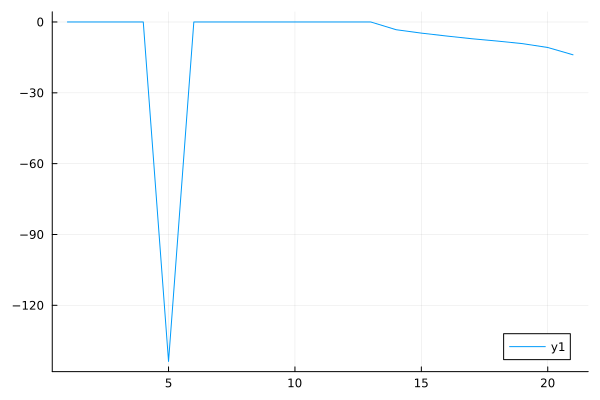

In [1551]:
plot(Um2[2,1:21])

In [1552]:
#plot(Um2[2,30:40])

In [1553]:
#Um2[2, 32]

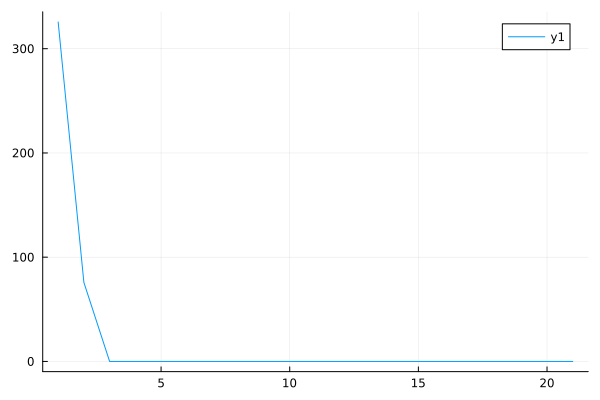

In [1554]:
plot(Um2[3,1:21])

In [1555]:
#for one period 40 controls
# xtraj_test2 = integrate_oneperiod(Xm2[:,1] + reference_trajectory[:,1], Um2[:,1:40])

In [1556]:
# plot(xtraj_test2[1,:], xtraj_test2[2,:], xtraj_test2[3,:])
#scatter!([xtraj_test2[1,1]], [xtraj_test2[2,1]], [xtraj_test2[3,1]])

In [1557]:
# xtraj_test2[:,1]

In [1558]:
# xtraj_test2[:,41]

In [1559]:
#similar to the first solve. No point in doing a second correction
#norm(xtraj_test2[:,1] - xtraj_test2[:,41])

In [1560]:
#norm(xtraj_test2[:,41] - reference_trajectory[:,41])

In [1561]:
#reference_trajectory[:,41]

In [1562]:
#find if the updated solution satisfies the constraints
#delta_test2 = xtraj_test2 - reference_trajectory

In [1563]:
#end_state = xtraj_test2[:,21]

#end_state_sim = just_dynamics_integrate(end_state, 2.75*sol_t_final[end])


#end_state_traj = get_state(end_state_sim)

In [1564]:
#plot(end_state_traj[1,:],end_state_traj[2,:])
#scatter!([end_state_traj[1,1]],[end_state_traj[2,1]])

In [1565]:
# constraint_satisfied_ndynamics2 = zeros(41)

# for i=1:41
#     constraint_satisfied_ndynamics2[i] = dot(delta_test2[:,i], unstable_directions[:,i])
# end

In [1566]:
# plot(constraint_satisfied_ndynamics2 .>0)

In [1567]:
#fixed the reference trajectory and added some slack on the halfspace constraint and it seems like I don't need to use the second order correction
#anymore

In [1568]:
#this initial condition is working
#x_initial_ref = [1e-4, 0, 0, 0, 1e-4, 0]

#x_initial_ref = [1e-6, 0, 0, 0, 1e-6, 0]


#x_initial_ref = [1e-3, 0, 0, 0, 1e-3, 0]

In [1569]:
# xposedeviation = x_initial_ref[1] * L*1e3 #in meters

# vyposedeviation = x_initial_ref[5]*V_*1e3 #in m/s

# display(xposedeviation)
# display(vyposedeviation)

In [1570]:
#this is one set of jacobians. if starting from beginning 

#all_Ad_1 = cat(all_Ad, all_Ad, dims=3)
#all_Bd_1 = cat(all_Bd, all_Bd, dims=3)

In [1571]:
all_Ad[:,:,21:end]

6×6×21 Array{Float64, 3}:
[:, :, 1] =
  1.0388        0.000783757  -0.0105826    …   0.00131767  -5.92649e-5
 -0.000352537   0.98403       0.000171031      0.016724    -8.3906e-7
 -0.0105881    -0.000369314   0.983451        -5.39991e-6   0.016787
  4.60917       0.137007     -1.24853          0.15794     -0.0104437
 -0.064338     -1.87614       0.0306664        0.972482    -0.000188587
 -1.24968      -0.0645265    -1.95124      …  -0.00125416   0.983483

[:, :, 2] =
  1.03766      0.00536305  -0.00989336   …   0.00134243  -5.45136e-5
  0.00423182   0.984991    -0.000853585      0.016732    -6.37954e-6
 -0.0098435   -0.00136167   0.983609        -1.05579e-5   0.0167881
  4.45813      0.669242    -1.15414          0.16217     -0.00949086
  0.468688    -1.75177     -0.0874734        0.974074    -0.00112456
 -1.14544     -0.176483    -1.92916      …  -0.0020912    0.983705

[:, :, 3] =
  1.03523      0.00900594  -0.00850522   0.0170053    0.00136104  -4.61369e-5
  0.00788792   0.987043   

In [1572]:
all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,2:21], dims=3)
all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,2:21], dims=3)

6×3×41 Array{Float64, 3}:
[:, :, 1] =
  0.000143107   7.3821e-6    -2.48481e-7
 -7.26712e-6    0.000141814  -1.31456e-8
 -2.48481e-7   -1.31456e-8    0.00014208
  0.0170278     0.00132397   -5.81706e-5
 -0.00128411    0.016726     -2.28649e-6
 -5.78192e-5   -6.76304e-6    0.0167872

[:, :, 2] =
  0.000143068   7.48635e-6   -2.27673e-7
 -7.16287e-6    0.000141848  -3.55095e-8
 -2.27673e-7   -3.55095e-8    0.000142085
  0.017017      0.00134718   -5.24316e-5
 -0.00126079    0.0167355    -7.29811e-6
 -5.17084e-5   -1.13163e-5    0.0167885

[:, :, 3] =
  0.000143003   7.565e-6     -1.92031e-7
 -7.08422e-6    0.000141904  -4.85434e-8
 -1.92031e-7   -4.85434e-8    0.000142094
  0.0170007     0.00136385   -4.35781e-5
 -0.00124393    0.0167493    -1.00808e-5
 -4.26654e-5   -1.34071e-5    0.016791

;;; … 

[:, :, 39] =
  0.000143068  7.16345e-6   -2.27795e-7
 -7.48578e-6   0.000141848   3.54008e-8
 -2.27795e-7   3.54008e-8    0.000142085
  0.0170233    0.0012718    -5.52668e-5
 -0.00133624   0.

In [1573]:
all_Ad_2 = cat(all_Ad_half, all_Ad_half[:,:,2:end], dims = 3)
all_Bd_2 = cat(all_Bd_half, all_Bd_half[:,:,2:end], dims=3)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
  0.000143107   7.3821e-6    -2.48481e-7
 -7.26712e-6    0.000141814  -1.31456e-8
 -2.48481e-7   -1.31456e-8    0.00014208
  0.0170278     0.00132397   -5.81706e-5
 -0.00128411    0.016726     -2.28649e-6
 -5.78192e-5   -6.76304e-6    0.0167872

[:, :, 2] =
  0.000143068   7.48635e-6   -2.27673e-7
 -7.16287e-6    0.000141848  -3.55095e-8
 -2.27673e-7   -3.55095e-8    0.000142085
  0.017017      0.00134718   -5.24316e-5
 -0.00126079    0.0167355    -7.29811e-6
 -5.17084e-5   -1.13163e-5    0.0167885

[:, :, 3] =
  0.000143003   7.565e-6     -1.92031e-7
 -7.08422e-6    0.000141904  -4.85434e-8
 -1.92031e-7   -4.85434e-8    0.000142094
  0.0170007     0.00136385   -4.35781e-5
 -0.00124393    0.0167493    -1.00808e-5
 -4.26654e-5   -1.34071e-5    0.016791

;;; … 

[:, :, 79] =
  0.000143068  7.16345e-6   -2.27795e-7
 -7.48578e-6   0.000141848   3.54008e-8
 -2.27795e-7   3.54008e-8    0.000142085
  0.0170233    0.0012718    -5.52668e-5
 -0.00133624   0.

In [1574]:
#another set of jacobians if starting from half

#all_Ad_half = cat(all_Ad[:,:,21:end], all_Ad[:,:,1:20], dims=3)
#all_Bd_half = cat(all_Bd[:,:,21:end], all_Bd[:,:,1:20], dims=3)

#all_Ad_2 = cat(all_Ad_half, all_Ad_half, dims=3)
#all_Bd_2 = cat(all_Bd_half, all_Bd_half, dims=3)

#All Ad1 is if you start from the beginning (2 orbits worth of jacobians) and all_Ad_2 is if you start from the half (2 orbits worth of jacobians).
#need to also have two sets of cost to go and unstable direction matrices that we pass in in the update_prob function 

In [1575]:
#unstable directions is good. Need to fix V_2orbits
unstable_directions_half = cat(unstable_directions[:,21:end], unstable_directions[:,2:21], dims=2)

#P is for the 16 orbits. Need the one for just 1 orbit
V_half = cat(V[:,:,21:end], V[:,:,2:21], dims=3)


#unstable directions if you start from the beginning
unstable_directions_2_1 = unstable_directions_2
#this is the unstable direction if you start at the half
unstable_directions_2_2 = cat(unstable_directions_half, unstable_directions_half[:,2:end], dims=2)


#cost to go if you start from the beginning
V_2orbits_1 = V_2orbits

#cost to go in you start at the half
V_2orbits_2 = cat(V_half, V_half[:,:,2:end], dims=3)

6×6×81 Array{Float64, 3}:
[:, :, 1] =
 377.901    -8.23728    -61.9715    16.8625     15.725     -1.85596
  -8.23728   0.191439     1.35043   -0.366674   -0.343423   0.0392886
 -61.9715    1.35043     10.1897    -2.76627    -2.57869    0.301547
  16.8625   -0.366674    -2.76627    0.752794    0.701235  -0.0827322
  15.725    -0.343423    -2.57869    0.701235    0.655081  -0.076995
  -1.85596   0.0392886    0.301547  -0.0827322  -0.076995   0.010196

[:, :, 2] =
 364.793    17.8557     -54.1597    16.0496     16.0153     -1.14459
  17.8557    0.885639    -2.65261    0.785742    0.784591   -0.0567386
 -54.1597   -2.65261      8.05941   -2.38352    -2.37736     0.169229
  16.0496    0.785742    -2.38352    0.70648     0.704194   -0.0502742
  16.0153    0.784591    -2.37736    0.704194    0.703808   -0.0500491
  -1.14459  -0.0567386    0.169229  -0.0502742  -0.0500491   0.0047394

[:, :, 3] =
 342.866    37.3068     -43.3948     15.1642     15.83       -0.45146
  37.3068    4.0757      -4.

In [1576]:
x_initial_ref_scaled

6-element Vector{Float64}:
 0.238529
 0.0
 0.0
 0.0
 1.0896687780891452
 0.0

In [1577]:
unstable_directions_2[:,1]

6-element Vector{Float64}:
 -0.08855910684745628
  0.02865744089746027
 -0.005939290756903623
 -0.8887776057645704
  0.4235137548994912
 -0.14836181248294958

In [1578]:
#pseudo code

orbit_count = 0
orbits = true

#number of orbits you want to plan go for
orbit_num = 100

halforbit_num = orbit_num*2 

#this is for each orbit plan

optimal_Δx = zeros(nx, N_period)
optimal_u = zeros(nu, N_period-1)

#data for all the orbits
all_optimal_Δx = zeros(nx, 21, halforbit_num)
all_optimal_x = zeros(nx, 21, halforbit_num)
all_optimal_u = zeros(nu, 20, halforbit_num)

solution_xm = zeros(6, 81, halforbit_num)
solution_um = zeros(6, 80, halforbit_num)

#optimal_Δx[:,1] = x_initial_ref


#while orbits
    
#    orbits=false
    
#for i=1:N_period-1
 
#i is now the number of times it orbits
for i=1:halforbit_num

        
    #Ad_k = cat(all_Ad_3p[:,:,i:end],all_Ad_3p[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd_3p[:,:,i:end],all_Bd_3p[:,:,1:(i-1)], dims=3)
    
    #Ad_k = cat(all_Ad[:,:,i:end],all_Ad[:,:,1:(i-1)], dims=3)
    #Bd_k = cat(all_Bd[:,:,i:end],all_Bd[:,:,1:(i-1)], dims=3)
    
    #Ad_k = all_Ad_3p[:,:,1:N_h]
    #Bd_k = all_Bd_3p[:,:,1:N_h]
      
    #horizon is two orbits ahead
    #all_Ad_k = cat(Ad_k, Ad_k, dims=3)
    #all_Bd_k = cat(Bd_k, Bd_k, dims=3)
        
    #cons, X, U = update_prob(optimal_Δx[:,i], all_Ad_k, all_Bd_k)
    
    #if you start from the beginning use the appropriate set of jacobians
    if i%2 != 0
        #println("using jacobian 1")
        all_Ad_k = all_Ad_1
        all_Bd_k = all_Bd_1
        unstable_directions_k = unstable_directions_2_1
        P_k = V_2orbits_1 
        reference_traj_k = reference_trajectory2       
    else
        #println("using jacobian 2")
        all_Ad_k = all_Ad_2
        all_Bd_k = all_Bd_2
        unstable_directions_k = unstable_directions_2_2
        P_k = V_2orbits_2
        reference_traj_k = reference_trajectory2_2
    end
    
    #the zeros is the bias 
    cons, X, U = update_prob(x_initial_ref_scaled, all_Ad_k, all_Bd_k, P_k, unstable_directions_k, zeros(6, N_h-1), reference_traj_k)
        
    Xm, Um = solve_opt(cons, X, U,N_h)

    solution_xm = Xm
    solution_um = Um
    
    #get the optimal controls for half a period (20 for this example)
        
    optimal_u = Um[:,1:20]
        
    #size N_period
        
    orbit_count += 1
    
    #rollout on the nonlinear dynamics
    if i%2 != 0
        
        #print("from beginning")
        
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,1] + Xm[:,1], optimal_u)

        #this is the deviation from the reference
        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,1:21]
        
        #integrate the initial condition by all the optimal controls from the solver        
    else
        
        #print("this is reference trajectory at half: ", reference_trajectory[:,21])
        #println("from half")
        xtraj_halfperiod = integrate_halfperiod(reference_trajectory[:,21] + Xm[:,1], optimal_u)

        all_optimal_Δx[:,:,orbit_count] = xtraj_halfperiod - reference_trajectory[:,21:41] 
        #integrate the initial condition by all the optimal controls from the solver
        
    end
    
    all_optimal_x[:,:,orbit_count] = xtraj_halfperiod
    
    all_optimal_u[:,:,orbit_count] = optimal_u
    
    println("Half Revolution solved: ", i)
    
    #update the intiial condition for the next rev (has to be a delta)
    x_initial_ref_scaled = all_optimal_Δx[:,end, orbit_count]

    #println("this is the initial condition for the next rev: ", x_initial_ref)
    
end  

Half Revolution solved: 1
Half Revolution solved: 2
Half Revolution solved: 3
Half Revolution solved: 4
Half Revolution solved: 5
Half Revolution solved: 6
Half Revolution solved: 7
Half Revolution solved: 8
Half Revolution solved: 9
Half Revolution solved: 10
Half Revolution solved: 11
Half Revolution solved: 12
Half Revolution solved: 13
Half Revolution solved: 14
Half Revolution solved: 15
Half Revolution solved: 16
Half Revolution solved: 17
Half Revolution solved: 18
Half Revolution solved: 19
Half Revolution solved: 20
Half Revolution solved: 21
Half Revolution solved: 22
Half Revolution solved: 23
Half Revolution solved: 24
Half Revolution solved: 25
Half Revolution solved: 26
Half Revolution solved: 27
Half Revolution solved: 28
Half Revolution solved: 29
Half Revolution solved: 30
Half Revolution solved: 31
Half Revolution solved: 32
Half Revolution solved: 33
Half Revolution solved: 34
Half Revolution solved: 35
Half Revolution solved: 36
Half Revolution solved: 37
Half Revol

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


93
Half Revolution solved: 94
Half Revolution solved: 95
Half Revolution solved: 96
Half Revolution solved: 97
Half Revolution solved: 98
Half Revolution solved: 99
Half Revolution solved: 100
Half Revolution solved: 101
Half Revolution solved: 102
Half Revolution solved: 103
Half Revolution solved: 104
Half Revolution solved: 105
Half Revolution solved: 106
Half Revolution solved: 107
Half Revolution solved: 108
Half Revolution solved: 109
Half Revolution solved: 110
Half Revolution solved: 111
Half Revolution solved: 112
Half Revolution solved: 113
Half Revolution solved: 114
Half Revolution solved: 115
Half Revolution solved: 116
Half Revolution solved: 117
Half Revolution solved: 118
Half Revolution solved: 119
Half Revolution solved: 120
Half Revolution solved: 121
Half Revolution solved: 122
Half Revolution solved: 123
Half Revolution solved: 124
Half Revolution solved: 125
Half Revolution solved: 126
Half Revolution solved: 127
Half Revolution solved: 128
Half Revolution solved:

┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


165
Half Revolution solved: 166
Half Revolution solved: 167
Half Revolution solved: 168
Half Revolution solved: 169
Half Revolution solved: 170
Half Revolution solved: 171
Half Revolution solved: 172
Half Revolution solved: 173
Half Revolution solved: 174
Half Revolution solved: 175
Half Revolution solved: 176


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


Half Revolution solved: 177
Half Revolution solved: 178
Half Revolution solved: 179
Half Revolution solved: 180
Half Revolution solved: 181
Half Revolution solved: 182
Half Revolution solved: 183
Half Revolution solved: 184
Half Revolution solved: 185
Half Revolution solved: 186
Half Revolution solved: 187
Half Revolution solved: 188
Half Revolution solved: 189
Half Revolution solved: 190
Half Revolution solved: 191
Half Revolution solved: 192
Half Revolution solved: 193
Half Revolution solved: 194
Half Revolution solved: 195
Half Revolution solved: 196
Half Revolution solved: 197
Half Revolution solved: 198
Half Revolution solved: 199
Half Revolution solved: 200


┌ Warning: Problem status SLOW_PROGRESS; solution may be inaccurate.
└ @ Convex /home/faustovega/.julia/packages/Convex/b2S4H/src/solution.jl:342


In [1579]:
#the current problem is that the linear problem does satisfy the dynamics, however, the nonlinear rollout breaks those dynamics. need second order
# correction for the MPC problem. FIXED 

In [1580]:
all_optimal_Δx

6×21×200 Array{Float64, 3}:
[:, :, 1] =
 0.238529  0.2444     0.253665   …   0.0313443   0.0206907   0.00879526
 0.0       0.017962   0.0337294     -0.340568   -0.33869    -0.327035
 0.0       0.0464555  0.151029       0.496383    0.350071    0.191108
 0.0       0.698645   0.404138      -0.593401   -0.669553   -0.735895
 1.08967   1.01263    0.854265      -0.175482    0.40512     0.97339
 0.0       5.49672    6.87601    …  -8.18478    -9.09922    -9.67305

[:, :, 2] =
  0.00879526  -0.00416378  -0.0172925  …   0.109991    0.107323    0.101754
 -0.327035    -0.306515    -0.27887        0.0406343   0.0311828   0.021943
  0.191108     0.0256909   -0.140828      -0.732965   -0.610154   -0.476546
 -0.735895    -0.789787    -0.754648      -0.0614055  -0.250096   -0.397312
  0.97339      1.44765      1.81003       -0.552729   -0.560052   -0.528815
 -9.67305     -9.8632      -9.80598    …   6.91207     7.61724     8.19211

[:, :, 3] =
  0.101754   0.0931337   0.0821802   …   0.0785921   0.0694

In [1581]:
dot(all_optimal_Δx[:,end,1], unstable_directions_2[:,21])

-1.02357935897719

In [1582]:
dot(all_optimal_Δx[:,end,2], unstable_directions_2[:,1])

-1.0917855796049383

In [1583]:
#dot(acceleration_scale[:,end,2], unstable_directions_2_2[:,21])

In [1584]:
solution_xm

6×81 Matrix{Float64}:
  0.0902322   0.0754866   0.058098  …   0.34046    0.398693   0.467626
 -0.143196   -0.137675   -0.125641     -0.357111  -0.399933  -0.442168
  0.536572    0.394333    0.237841      0.916006   0.824043   0.696045
 -0.742241   -0.98568    -1.05219       3.20121    3.72935    4.48135
  0.131178    0.524466    0.89645      -2.51694   -2.5391    -2.44554
 -7.89372    -8.90613    -9.5757    …  -4.35191   -6.53518   -8.59865

In [1585]:
unstable_directions_2_2

6×81 Matrix{Float64}:
 -0.0594335   -0.062374    -0.066039   …  -0.0573801   -0.0594335
  0.0554804    0.0533428    0.050904       0.0573059    0.0554804
  0.00652186   0.00891078   0.0111293      0.00407322   0.00652186
 -0.825521    -0.865556    -0.898968      -0.78103     -0.825521
  0.513911     0.43553      0.359251       0.588119     0.513911
  0.218534     0.233046     0.236051   …   0.193689     0.218534

In [1586]:
xtraj_halfperiod_test = integrate_halfperiod(reference_trajectory[:,21] + solution_xm[:,1], optimal_u)

6×21 Matrix{Float64}:
    2.39289e5     2.3929e5     2.39292e5  …      2.39585e5      2.39588e5
   -0.143196     79.9376     157.282            70.7974         0.0742963
 -175.19       -171.997     -162.356           223.248        225.372
   -0.742245     85.1275     188.182           291.128         -0.199027
 4771.41       4689.23      4449.86          -4157.8        -4205.59
   -7.89372     384.183      752.258      …    245.227          6.1141

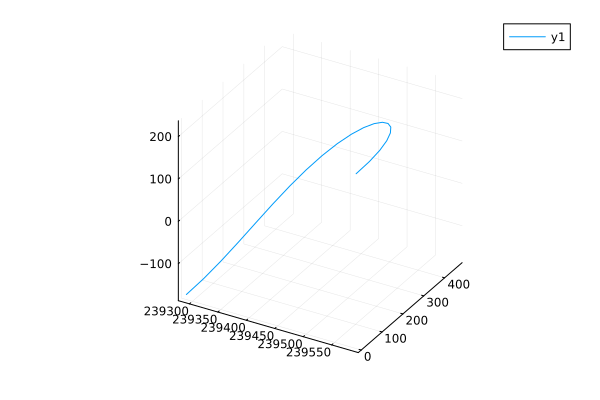

In [1588]:
plot(xtraj_halfperiod_test[1,:],xtraj_halfperiod_test[2,:], xtraj_halfperiod_test[3,:])

In [1589]:
test_deltas = xtraj_halfperiod_test - reference_trajectory[:,21:end]

6×21 Matrix{Float64}:
  0.0902322   0.075494   0.0581238  …   0.172292    0.174799    0.173274
 -0.143196   -0.137675  -0.125641       0.0982461   0.0868422   0.0742963
  0.536572    0.394327   0.237827      -0.971602   -0.891796   -0.796049
 -0.742241   -0.984814  -1.05084        0.270568    0.0262581  -0.199026
  0.131178    0.524481   0.896409      -0.625676   -0.717403   -0.761029
 -7.89372    -8.90645   -9.57619    …   4.22551     5.21549     6.1141

In [1590]:
test_deltas - solution_xm[:,1:21]

6×21 Matrix{Float64}:
 0.0   7.42454e-6    2.58305e-5    5.06014e-5   …   0.00402807    0.00487414
 0.0  -9.75009e-8   -5.03018e-7   -2.49244e-6      -0.000936452  -0.00131979
 0.0  -5.22745e-6   -1.47207e-5   -2.57697e-5       0.00024237    0.000378949
 0.0   0.000865515   0.00135219    0.00163122       0.0462722     0.0541541
 0.0   1.4556e-5    -4.15388e-5   -0.000161542     -0.0195176    -0.0261289
 0.0  -0.000327175  -0.000495803  -0.00055405   …   0.00719906    0.00899398

In [1591]:
#linear problem is good
solution_xm[:, 1:21]

6×21 Matrix{Float64}:
  0.0902322   0.0754866   0.058098  …   0.168985    0.170771    0.1684
 -0.143196   -0.137675   -0.125641      0.0988985   0.0877786   0.0756161
  0.536572    0.394333    0.237841     -0.971736   -0.892038   -0.796428
 -0.742241   -0.98568    -1.05219       0.231189   -0.0200141  -0.25318
  0.131178    0.524466    0.89645      -0.611368   -0.697885   -0.7349
 -7.89372    -8.90613    -9.5757    …   4.21988     5.20829     6.1051

In [1592]:
#linear problem is good and solves
test = zeros(21)

for k=1:21
    test[k] = dot(test_deltas[:,k], unstable_directions_2_2[:,k])

end


In [1593]:
test

21-element Vector{Float64}:
 -1.05470433555998
 -1.0033144929190752
 -1.0013494284330244
 -1.001686552604662
 -1.001971290331342
 -1.0023394263118313
 -1.0028903804657432
 -1.0036955701794674
 -1.0047998745423437
 -1.0062352078434558
  ⋮
 -1.0128512693135105
 -1.01597749547814
 -1.0196730083808776
 -1.0240303627174356
 -1.029166359240348
 -1.0352275101206008
 -1.042396119132629
 -1.0508967253205732
 -1.0610030290644752

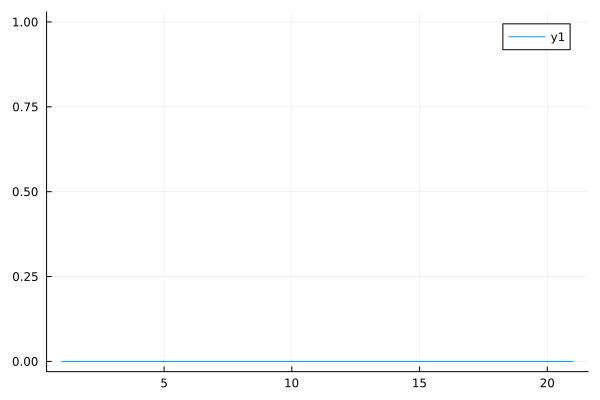

In [1594]:
plot(test .>0)

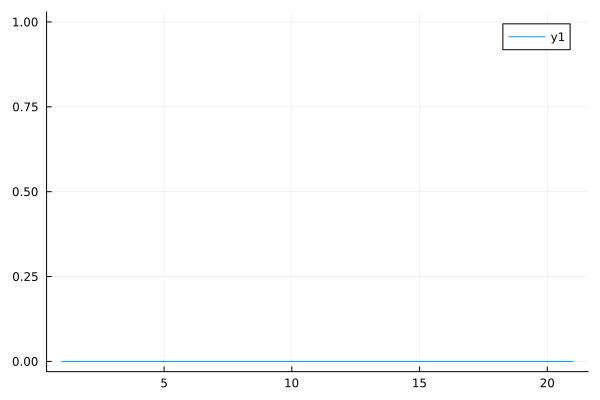

In [1595]:
plot(test.>0)

In [1596]:
rev1 = all_optimal_x[:,:,1]
rev2 = all_optimal_x[:,:,2]
rev3 = all_optimal_x[:,:,3]
rev4 = all_optimal_x[:,:,4]
rev5 = all_optimal_x[:,:,5]
# rev20 = all_optimal_x[:,:,20]

# rev59 = all_optimal_x[:,:,59]
# rev60 = all_optimal_x[:,:,60]
#rev25 = all_optimal_x[:,:,25]

6×21 Matrix{Float64}:
     2.39588e5       2.39585e5  239578.0    …     2.3929e5     2.39289e5
     0.00951136    -70.7161       -139.835      -80.2437      -0.163635
   225.548         223.639         217.714     -171.704     -175.174
    -0.389822     -291.7          -572.05       -86.5356      -0.705892
 -4205.76        -4157.93        -4015.77      4688.79      4771.78
     6.76489      -232.654        -468.359  …  -400.328       -8.57402

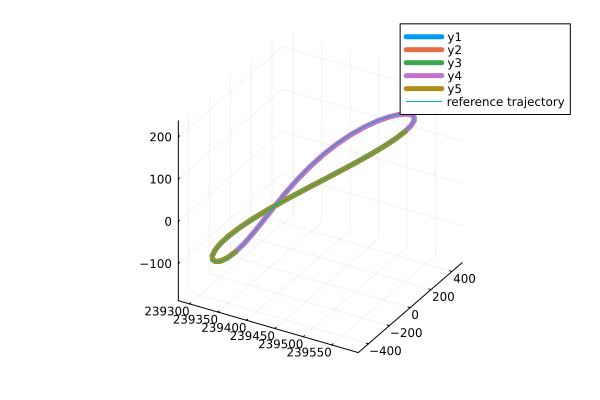

In [1597]:
plot(rev1[1,:], rev1[2,:], rev1[3,:], lw=5)
#scatter!([rev1[1,1]],[rev1[2,1]],[rev1[3,1]], lw=5)
plot!(rev2[1,:], rev2[2,:], rev2[3,:], lw=5)
plot!(rev3[1,:], rev3[2,:], rev3[3,:], lw=5)
plot!(rev4[1,:], rev4[2,:], rev4[3,:], lw=5)
plot!(rev5[1,:], rev5[2,:], rev5[3,:], lw=5)
#plot!(rev59[1,:], rev59[2,:], rev59[3,:], lw=5)
#plot!(rev60[1,:], rev60[2,:], rev60[3,:], lw=5)

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="reference trajectory")

#scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]])

In [1598]:
1e-3*L

238.529

In [1599]:
all_optimal_x_formatted = zeros(6, N_period, orbit_num)
all_optimal_Δx_formatted = zeros(6, N_period, orbit_num)

6×41×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] 

In [1600]:
#have orbit_num trajectories of N knot points

for i=1:orbit_num
    
    all_optimal_x_formatted[:,1:21,i] = all_optimal_x[:,:,(2*i-1)]
    
    #2:end is used to not repeat the same element twice
    all_optimal_x_formatted[:,22:end,i] = all_optimal_x[:,2:end,(2*i)]
    
    
    all_optimal_Δx_formatted[:,1:21,i] = all_optimal_Δx[:,:,(2*i-1)]
    
    all_optimal_Δx_formatted[:,22:end,i] = all_optimal_Δx[:,2:end,(2*i)]
    
end

In [1601]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
     2.39588e5        2.39585e5      2.39578e5  …     2.3929e5     2.39289e5
     2.88578e-15    -70.6926      -139.782          -80.4139      -0.327035
   226.168          224.186        218.238         -172.041     -175.536
    -9.46749e-10   -290.403       -570.955          -86.7819      -0.735898
 -4203.74         -4156.07       -4014.17          4689.11      4772.25
    -9.76991e-10   -234.515       -469.311      …  -402.189       -9.67305

[:, :, 2] =
    2.39289e5     2.3929e5     2.39292e5  …      2.39585e5      2.39588e5
   -0.327035     79.7687     157.129            70.7417         0.0219431
 -175.536      -172.365     -162.734           223.53         225.692
   -0.735898     85.3225     188.478           290.851         -0.397314
 4772.25       4690.16      4450.77          -4157.64       -4205.36
   -9.67305     383.227      752.029      …    247.629          8.19211

[:, :, 3] =
     2.39588e5      2.39585e5      2.39578e5  …     2

In [1602]:
all_optimal_x_formatted

6×41×100 Array{Float64, 3}:
[:, :, 1] =
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7417         0.0219431
   226.168          224.186           223.53         225.692
    -9.46749e-10   -290.403           290.851         -0.397314
 -4203.74         -4156.07          -4157.64       -4205.36
    -9.76991e-10   -234.515      …    247.629          8.19211

[:, :, 2] =
     2.39588e5      2.39585e5      2.39578e5  …      2.39585e5      2.39588e5
     0.021943     -70.6971      -139.809            70.7361         0.0095114
   225.692        223.806        217.901           223.411        225.548
    -0.397312    -291.717       -572.032           290.891         -0.389823
 -4205.36       -4157.55       -4015.4           -4158.04       -4205.76
     8.19211     -231.383       -467.266      …    246.069          6.76489

[:, :, 3] =
     2.39588e5       2.39585e5  239578.0    …      2.39585e5      2.39588e5
     0.00951136    -70.7

In [1603]:
all_xtraj = reshape(all_optimal_x_formatted, (6, N_period*orbit_num))

all_Δxtraj = reshape(all_optimal_Δx_formatted, (6, N_period*orbit_num))
#all_xtraj = reshape(all_optimal_x, (6, 210))

6×4100 Matrix{Float64}:
 0.238529  0.2444     0.253665   …   0.172292    0.174799    0.173274
 0.0       0.017962   0.0337294      0.0982461   0.0868422   0.0742963
 0.0       0.0464555  0.151029      -0.971602   -0.891796   -0.796049
 0.0       0.698645   0.404138       0.270568    0.0262581  -0.199026
 1.08967   1.01263    0.854265      -0.625676   -0.717403   -0.761029
 0.0       5.49672    6.87601    …   4.22551     5.21549     6.1141

In [1604]:
normz = zeros(4100)

4100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [1605]:
all_Δxtraj 

6×4100 Matrix{Float64}:
 0.238529  0.2444     0.253665   …   0.172292    0.174799    0.173274
 0.0       0.017962   0.0337294      0.0982461   0.0868422   0.0742963
 0.0       0.0464555  0.151029      -0.971602   -0.891796   -0.796049
 0.0       0.698645   0.404138       0.270568    0.0262581  -0.199026
 1.08967   1.01263    0.854265      -0.625676   -0.717403   -0.761029
 0.0       5.49672    6.87601    …   4.22551     5.21549     6.1141

In [1606]:
6.84/86400 

7.916666666666666e-5

In [1607]:
for i=1:4100
    normz[i] = norm(all_Δxtraj[1:3,i])
end

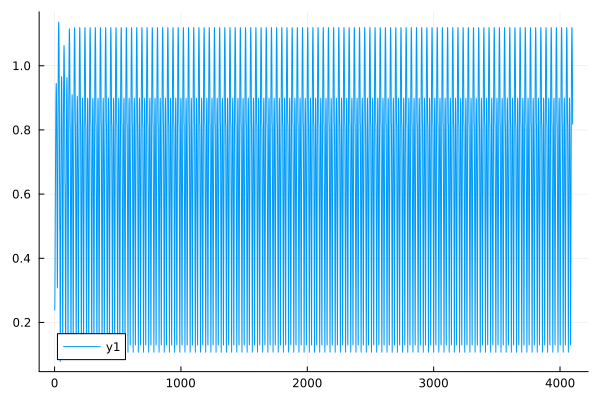

In [1608]:
plot(normz)

In [1609]:
all_xtraj 

6×4100 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7974         0.0742963
   226.168          224.186           223.248        225.372
    -9.46749e-10   -290.403           291.128         -0.199027
 -4203.74         -4156.07          -4157.8        -4205.59
    -9.76991e-10   -234.515      …    245.227          6.1141

In [1610]:
for i=1:100
    deltaxsub = all_Δxtraj[41*(i-1)+1:41*i]

    for i=1:41
        plot(deltaxsub[1,:], deltaxsub[2,:], deltaxsub[3,:], lw=5)
    end
end

In [1611]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
  -2.65276    -63.1859     -50.0483      …   2.53823e-9     3.14449e-9
  -1.8505e-9   -2.9899e-9   -7.15413e-9     -9.14008      -10.7911
 320.28        81.0107       2.71165e-8      1.27801e-10    1.90575e-10

[:, :, 2] =
  -1.65031    -5.6206e-10    6.92066e-10  …  -4.67481     -4.50203
 -13.9292    -15.5675       -7.02042         -2.45468e-8  -1.43661e-8
   0.381055   -6.99075     -25.8588          -9.71317e-9  -1.43564e-8

[:, :, 3] =
 -11.5593      -5.15701     -5.07852     …   1.0933e-10   1.17196e-9
  -7.03877e-9  -6.69112e-9  -5.09363e-9     -1.8845e-9   -3.68105e-9
  -7.93023e-9  -1.29865e-8  -2.7742e-8       9.65536e-9   3.18439e-8

;;; … 

[:, :, 198] =
 -3.12172       2.9033e-11    7.25054e-11  …  -10.1108       -9.59414
 -3.40508e-10  -0.704621     -2.46301          -2.08845e-10  -1.52399e-10
  2.3902e-10    3.29919e-10   0.770156          8.86618e-11   4.97357e-11

[:, :, 199] =
 -13.8112      -9.03754      -8.42671      …   2.59351

In [1612]:
all_optimal_u

3×20×200 Array{Float64, 3}:
[:, :, 1] =
  -2.65276    -63.1859     -50.0483      …   2.53823e-9     3.14449e-9
  -1.8505e-9   -2.9899e-9   -7.15413e-9     -9.14008      -10.7911
 320.28        81.0107       2.71165e-8      1.27801e-10    1.90575e-10

[:, :, 2] =
  -1.65031    -5.6206e-10    6.92066e-10  …  -4.67481     -4.50203
 -13.9292    -15.5675       -7.02042         -2.45468e-8  -1.43661e-8
   0.381055   -6.99075     -25.8588          -9.71317e-9  -1.43564e-8

[:, :, 3] =
 -11.5593      -5.15701     -5.07852     …   1.0933e-10   1.17196e-9
  -7.03877e-9  -6.69112e-9  -5.09363e-9     -1.8845e-9   -3.68105e-9
  -7.93023e-9  -1.29865e-8  -2.7742e-8       9.65536e-9   3.18439e-8

;;; … 

[:, :, 198] =
 -3.12172       2.9033e-11    7.25054e-11  …  -10.1108       -9.59414
 -3.40508e-10  -0.704621     -2.46301          -2.08845e-10  -1.52399e-10
  2.3902e-10    3.29919e-10   0.770156          8.86618e-11   4.97357e-11

[:, :, 199] =
 -13.8112      -9.03754      -8.42671      …   2.59351

In [1613]:
all_optimal_u 

3×20×200 Array{Float64, 3}:
[:, :, 1] =
  -2.65276    -63.1859     -50.0483      …   2.53823e-9     3.14449e-9
  -1.8505e-9   -2.9899e-9   -7.15413e-9     -9.14008      -10.7911
 320.28        81.0107       2.71165e-8      1.27801e-10    1.90575e-10

[:, :, 2] =
  -1.65031    -5.6206e-10    6.92066e-10  …  -4.67481     -4.50203
 -13.9292    -15.5675       -7.02042         -2.45468e-8  -1.43661e-8
   0.381055   -6.99075     -25.8588          -9.71317e-9  -1.43564e-8

[:, :, 3] =
 -11.5593      -5.15701     -5.07852     …   1.0933e-10   1.17196e-9
  -7.03877e-9  -6.69112e-9  -5.09363e-9     -1.8845e-9   -3.68105e-9
  -7.93023e-9  -1.29865e-8  -2.7742e-8       9.65536e-9   3.18439e-8

;;; … 

[:, :, 198] =
 -3.12172       2.9033e-11    7.25054e-11  …  -10.1108       -9.59414
 -3.40508e-10  -0.704621     -2.46301          -2.08845e-10  -1.52399e-10
  2.3902e-10    3.29919e-10   0.770156          8.86618e-11   4.97357e-11

[:, :, 199] =
 -13.8112      -9.03754      -8.42671      …   2.59351

In [1614]:
all_utraj = reshape(all_optimal_u, (3, (N_period-1)*orbit_num))

3×4000 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -10.1108       -9.59415
  -1.8505e-9   -2.9899e-9   -7.15413e-9      -1.81826e-10  -1.19926e-10
 320.28        81.0107       2.71165e-8       7.66189e-11   3.40963e-11

In [1615]:
all_utraj

3×4000 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -10.1108       -9.59415
  -1.8505e-9   -2.9899e-9   -7.15413e-9      -1.81826e-10  -1.19926e-10
 320.28        81.0107       2.71165e-8       7.66189e-11   3.40963e-11

In [1616]:
all_utraj_scaled = all_utraj/acceleration_scale

3×4000 Matrix{Float64}:
 -5.32905e-7   -1.26932e-5   -1.00541e-5   …  -2.03114e-6   -1.92734e-6
 -3.71741e-16  -6.00633e-16  -1.43717e-15     -3.65264e-17  -2.40915e-17
  6.43401e-5    1.6274e-5     5.44736e-15      1.53918e-17   6.84951e-18

In [1617]:
#save all u traj scaled to a text file for the test simulation
#cr3bp units 
using DelimitedFiles

#writedlm("utraj.txt", all_utraj_scaled, ',')

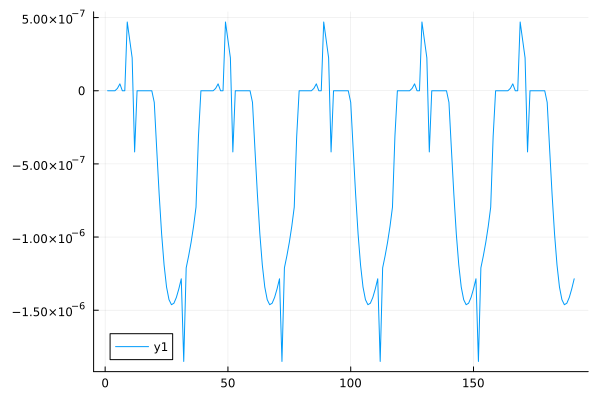

In [1618]:
plot(all_utraj[1,410:600]*1e3/86400^2)

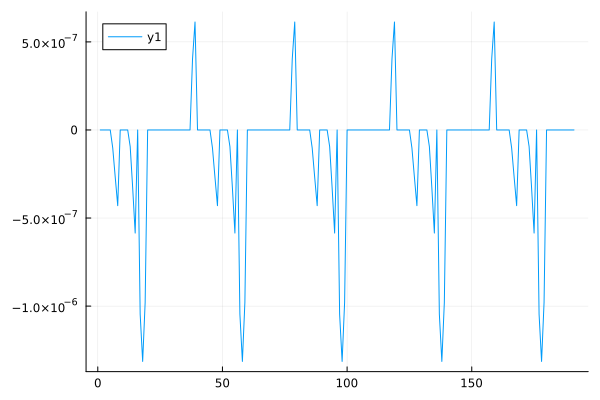

In [1619]:
plot(all_utraj[2,410:600]*1e3/86400^2)

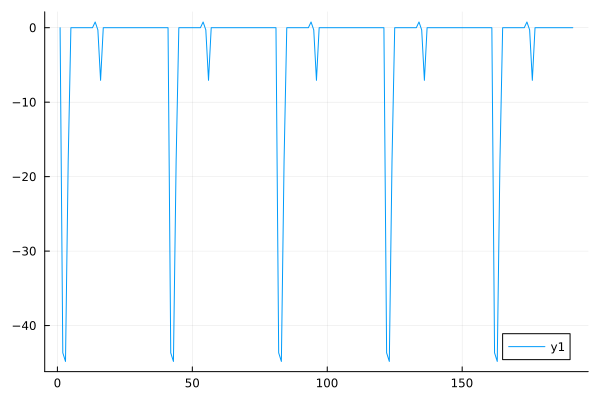

In [1620]:
plot(all_utraj[3,410:600])

In [1621]:
horizon 

41-element LinRange{Float64, Int64}:
 0.0, 0.0168805, 0.0337609, 0.0506414, …, 0.641457, 0.658338, 0.675218

In [1622]:
Δt*41

0.6920987309631694

In [1623]:
T*time_scale 

0.6752182741104091

In [1624]:
days_range 

0.0:1.0:409.0

In [1625]:
Δt

0.01688045685276023

In [1626]:
days_range = range(0,409, 410)

days = collect(days_range)*Δt

410-element Vector{Float64}:
 0.0
 0.01688045685276023
 0.03376091370552046
 0.05064137055828069
 0.06752182741104092
 0.08440228426380114
 0.10128274111656138
 0.1181631979693216
 0.13504365482208183
 0.15192411167484207
 ⋮
 6.769063197956852
 6.785943654809612
 6.802824111662372
 6.8197045685151325
 6.836585025367893
 6.853465482220653
 6.870345939073413
 6.887226395926174
 6.904106852778933

In [1627]:
days[41]

0.6752182741104091

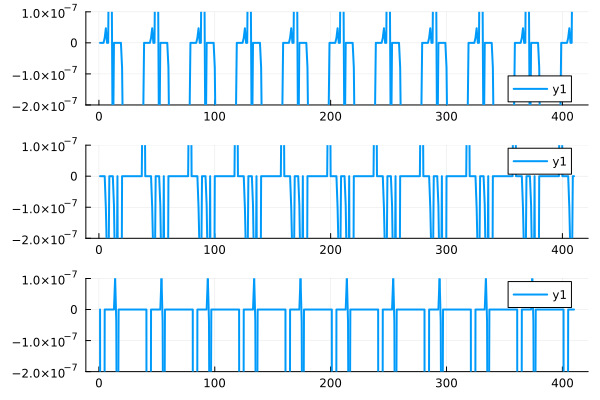

In [1628]:
plot_range = (-2e-7, 10e-8)

plot1 = plot(all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range,xlabel="")
plot2 = plot(all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range)
plot3 = plot(all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range)


plot_layout = @layout [a;
                       b; 
                       c]

plot(plot1, plot2, plot3, layout=plot_layout)

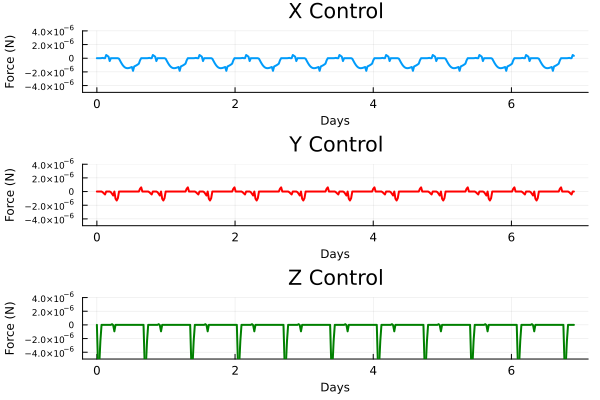

In [1629]:
#this plots orbits 10-20
plot_range = (-5e-6, 4e-6)


plot1 = plot(days, all_utraj[1,410:819]*1e3/86400^2, linewidth = 2,ylim = plot_range, title= "X Control")
plot2 = plot(days, all_utraj[2,410:819]*1e3/86400^2, linewidth = 2, ylim = plot_range, title= "Y Control", linecolor="red")
plot3 = plot(days , all_utraj[3,410:819]*1e3/86400^2, linewidth=2, ylim = plot_range, title= "Z Control", linecolor="green")


plot_layout = @layout [a;
                       b; 
                       c]

control1020 = plot(plot1, plot2, plot3, layout=plot_layout, legend=false, xlabel="Days", xlabelfontsize=8, ylabel="Force (N)", ylabelfontsize=8, ytickfontsize = 6)

In [1630]:
#writedlm("utraj_enceledus_tube.txt", all_utraj, ',')

In [1737]:
#writedlm("xtraj_enceledus_tube_v4.txt", all_xtraj, ',')

In [1632]:
#savefig(control1020, "enceledus_ctg")

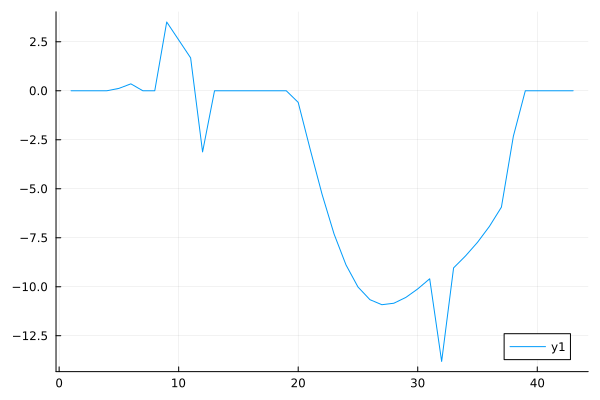

In [1633]:
plot(all_utraj[1,410:452])

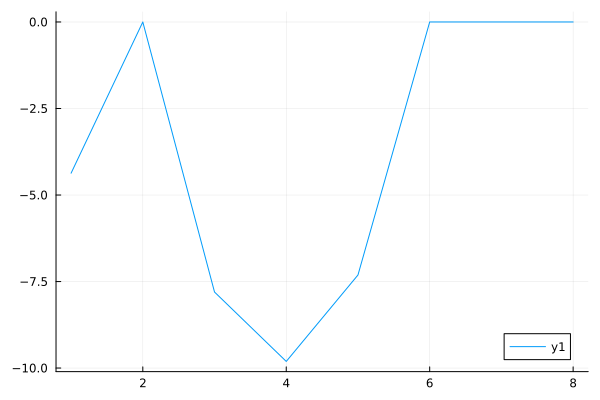

In [1634]:
plot(all_utraj[2,424:431])

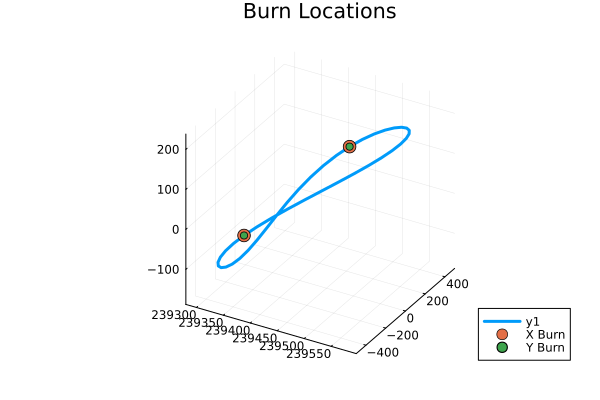

In [1635]:
burn_locations = plot(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], linewidth = 3, title= "Burn Locations")
scatter!([reference_trajectory[1,12], reference_trajectory[1,31]],[reference_trajectory[2,12], reference_trajectory[2,31]],[reference_trajectory[3,12], reference_trajectory[3,31]], label="X Burn", markersize = 7)
scatter!([reference_trajectory[1,12], reference_trajectory[1,31]],[reference_trajectory[2,12], reference_trajectory[2,31]],[reference_trajectory[3,12], reference_trajectory[3,31]], label="Y Burn", markersize = 4)

In [1636]:
reference_trajectory[:,12]

6-element Vector{Float64}:
 239382.91098401017
   -468.2921961583632
     18.14468342477443
  -1363.0067541623266
    421.19538332748994
  -1844.2944762437294

In [1637]:
#savefig( burn_locations, "burn_locations")

In [1638]:
#savefig( control1020, "control1020")

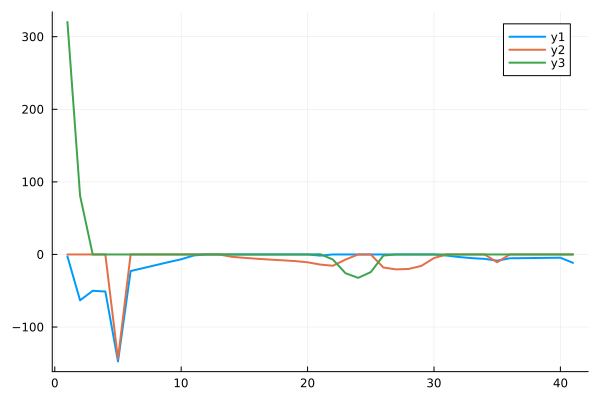

In [1639]:
plot(all_utraj[1,1:41], linewidth = 2)
plot!(all_utraj[2,1:41], linewidth = 2)
plot!(all_utraj[3,1:41], linewidth=2)

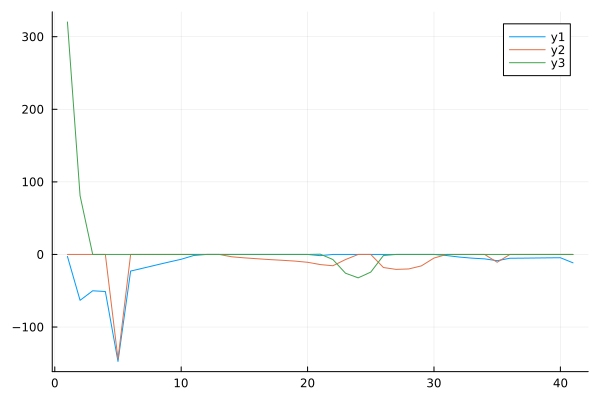

In [1640]:
plot(all_utraj[1,1:41])
plot!(all_utraj[2,1:41])
plot!(all_utraj[3,1:41])

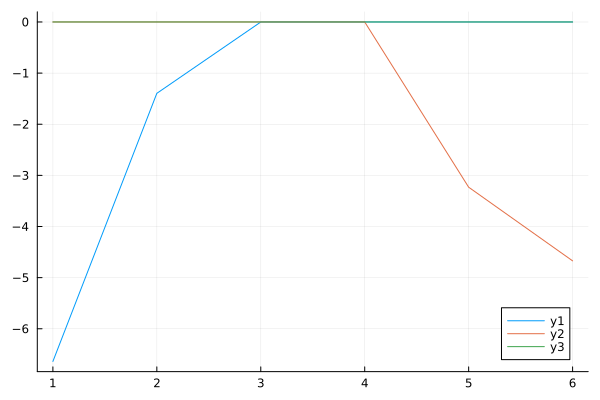

In [1641]:
plot(all_utraj[1,10:15])
plot!(all_utraj[2,10:15])
plot!(all_utraj[3,10:15])

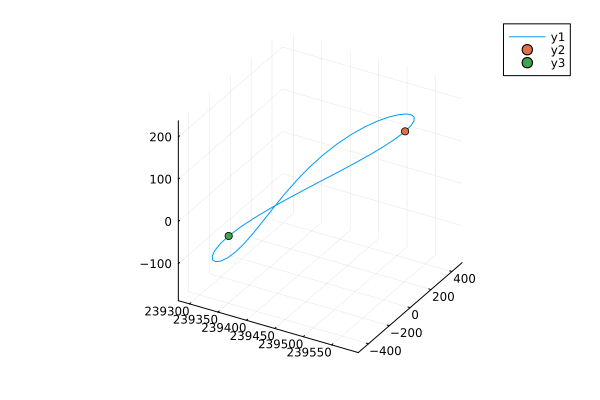

In [1642]:
plot(all_xtraj[1,1:41], all_xtraj[2,1:41], all_xtraj[3,1:41])


scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]])
scatter!([all_xtraj[1,13]], [all_xtraj[2,13]], [all_xtraj[3,13]])

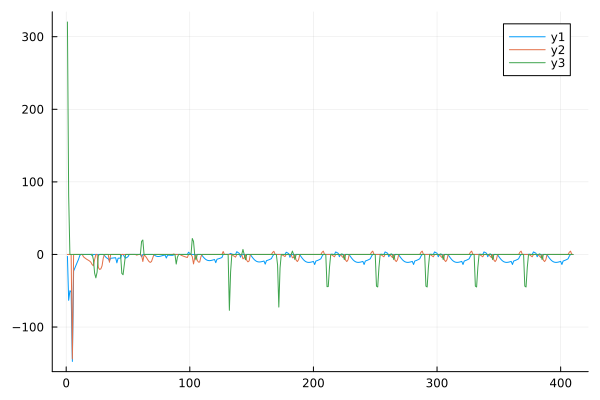

In [1643]:
#this is for 5 orbits
plot(all_utraj[1,1:410])
plot!(all_utraj[2,1:410])
plot!(all_utraj[3,1:410])

In [1644]:
# size(all_utraj)

In [1646]:
one_orbit = all_utraj[:,41:80]

3×40 Matrix{Float64}:
 -11.5593      -5.15701     -5.07852     …  -1.09671      -0.746502
  -7.03877e-9  -6.69112e-9  -5.09363e-9      1.99495e-10   1.23151e-9
  -7.93023e-9  -1.29865e-8  -2.7742e-8      -2.15562e-9   -3.05877e-9

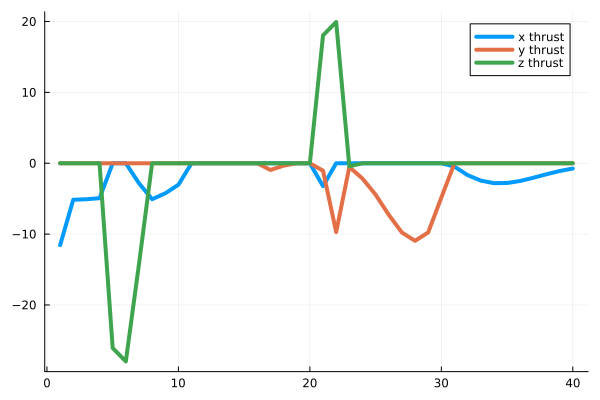

In [1647]:
#the beginning thrust is to get it back on track since the initialization is off by 1e-3

plot(one_orbit[1,:], label="x thrust", linewidth=4)

plot!(one_orbit[2,:], label="y thrust", linewidth=4)

plot!(one_orbit[3,:], label="z thrust", linewidth=4)

In [1648]:
#once we are at the orbit this is what it looks like
last_orbit = all_utraj[:,3961:end]

3×40 Matrix{Float64}:
 -13.8112      -9.03754      -8.42671      …  -10.1108       -9.59415
  -1.24113e-9  -3.87099e-10   6.63479e-10      -1.81826e-10  -1.19926e-10
   2.92565e-9   1.22679e-9   -1.33053e-10       7.66189e-11   3.40963e-11

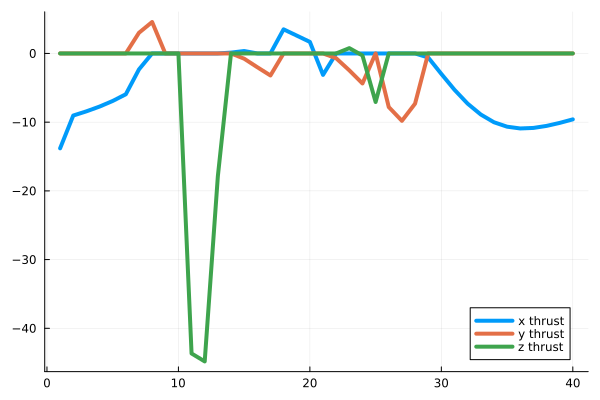

In [1649]:
plot(last_orbit[1,:], label="x thrust", linewidth=4)

plot!(last_orbit[2,:], label="y thrust", linewidth=4)

plot!(last_orbit[3,:], label="z thrust", linewidth=4)

In [1650]:
all_xtraj

6×4100 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7974         0.0742963
   226.168          224.186           223.248        225.372
    -9.46749e-10   -290.403           291.128         -0.199027
 -4203.74         -4156.07          -4157.8        -4205.59
    -9.76991e-10   -234.515      …    245.227          6.1141

In [1651]:
all_utraj 

3×4000 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -10.1108       -9.59415
  -1.8505e-9   -2.9899e-9   -7.15413e-9      -1.81826e-10  -1.19926e-10
 320.28        81.0107       2.71165e-8       7.66189e-11   3.40963e-11

In [1652]:
norm(all_utraj[:,1])

320.29076303481236

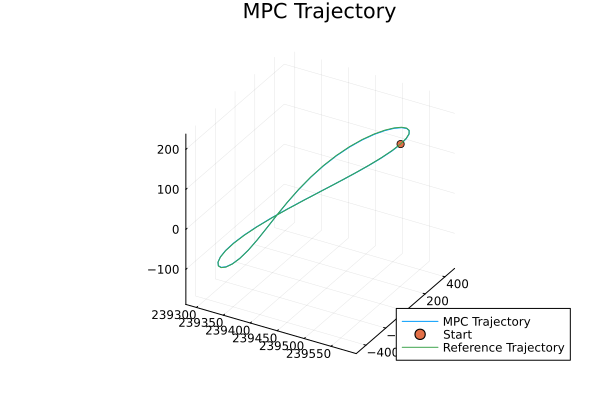

In [1653]:
#plot the 100 orbits

plot(all_xtraj[1,:], all_xtraj[2,:], all_xtraj[3,:], label="MPC Trajectory", title="MPC Trajectory")

scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")

plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label = "Reference Trajectory")

In [1654]:
all_xtraj 

6×4100 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7974         0.0742963
   226.168          224.186           223.248        225.372
    -9.46749e-10   -290.403           291.128         -0.199027
 -4203.74         -4156.07          -4157.8        -4205.59
    -9.76991e-10   -234.515      …    245.227          6.1141

In [1655]:
all_xtraj

6×4100 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7974         0.0742963
   226.168          224.186           223.248        225.372
    -9.46749e-10   -290.403           291.128         -0.199027
 -4203.74         -4156.07          -4157.8        -4205.59
    -9.76991e-10   -234.515      …    245.227          6.1141

In [1656]:
all_xtraj[1:3,41]/L 

3-element Vector{Float64}:
 1.0044385763957937
 9.199324558690546e-8
 0.0009461822111776977

In [1657]:
all_xtraj[4:6,41]/V_ 

3-element Vector{Float64}:
 -3.646188261270452e-7
 -0.0038593014594030606
  7.517977179201152e-6

In [1658]:
all_xtraj

6×4100 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7974         0.0742963
   226.168          224.186           223.248        225.372
    -9.46749e-10   -290.403           291.128         -0.199027
 -4203.74         -4156.07          -4157.8        -4205.59
    -9.76991e-10   -234.515      …    245.227          6.1141

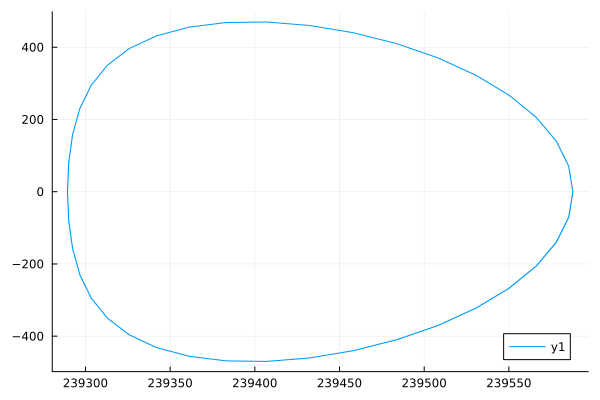

In [1659]:
plot(all_xtraj[1, :],all_xtraj[2, :])

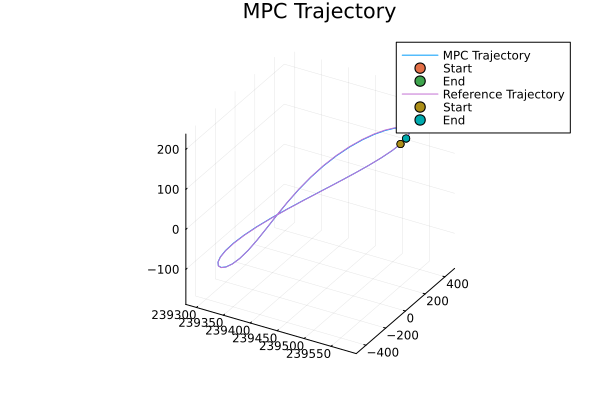

In [1660]:
iter = 40

plot(all_xtraj[1,1:iter], all_xtraj[2,1:iter], all_xtraj[3,1:iter], label="MPC Trajectory", title="MPC Trajectory")
scatter!([all_xtraj[1,1]], [all_xtraj[2,1]], [all_xtraj[3,1]], label="Start")
scatter!([all_xtraj[1,iter]], [all_xtraj[2,iter]], [all_xtraj[3,iter]], label="End")
plot!(reference_trajectory[1,1:iter], reference_trajectory[2,1:iter], reference_trajectory[3,1:iter], label = "Reference Trajectory")
scatter!([reference_trajectory[1,1]], [reference_trajectory[2,1]], [reference_trajectory[3,1]], label="Start")
scatter!([reference_trajectory[1,iter]], [reference_trajectory[2,iter]], [reference_trajectory[3,iter]], label="End")


In [1661]:
#plot the final orbit
size(all_xtraj)

(6, 4100)

In [1662]:
#i = 50
#plot(all_xtraj[1,40*(i-1)+1:40*i], all_xtraj[2,40*(i-1)+1:40*i], all_xtraj[3,40*(i-1)+1:40*i], label="MPC Trajectory", title="MPC Trajectory",lw=3)


#plot!(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory",lw=3)
#plot!(all_xtraj[1,81:120], all_xtraj[2,81:120], all_xtraj[3,81:120], label="MPC Trajectory", title="MPC Trajectory",lw=3)



#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3)


#plot(all_xtraj[1,41:80], all_xtraj[2,41:80], all_xtraj[3,41:80], label="MPC Trajectory", title="MPC Trajectory", lw=3)
#plot(all_xtraj[1,81:end], all_xtraj[2,81:end], all_xtraj[3,81:end], label="MPC Trajectory", title="MPC Trajectory", lw=3)

#scatter!([all_xtraj[1,1]],[all_xtraj[2,1]], [all_xtraj[3,1]], label="1")

#scatter!([all_xtraj[1,40]],[all_xtraj[2,40]], [all_xtraj[3,40]], label="40")

#scatter!([all_xtraj[1,41]],[all_xtraj[2,41]], [all_xtraj[3,41]], label="41")

#scatter!([all_xtraj[1,81]],[all_xtraj[2,81]], [all_xtraj[3,81]], label="80")

In [1663]:
#plot(optimal_u[1,:].*acceleration_scale)

In [1664]:
#plot(optimal_u[2,:])

In [1665]:
#plot(optimal_u[3,:])

In [1666]:
#acceleration_scale

In [1667]:
#scaled_control.*acceleration_scale

In [1668]:
#all_utraj

In [1669]:
all_xtraj[:,21]

6-element Vector{Float64}:
 239289.354597057
     -0.3270350853126144
   -175.53550922134352
     -0.7358982580662985
   4772.254584258744
     -9.673051545044444

In [1670]:
all_xtraj[:,22]

6-element Vector{Float64}:
 239290.05559289755
     79.7687104782295
   -172.36535039355815
     85.32251201989831
   4690.155990358522
    383.22651163095526

In [1671]:
all_utraj

3×4000 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -10.1108       -9.59415
  -1.8505e-9   -2.9899e-9   -7.15413e-9      -1.81826e-10  -1.19926e-10
 320.28        81.0107       2.71165e-8       7.66189e-11   3.40963e-11

In [1672]:
#this is already in units of km/(days)^2
scaled_control = all_utraj

3×4000 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -10.1108       -9.59415
  -1.8505e-9   -2.9899e-9   -7.15413e-9      -1.81826e-10  -1.19926e-10
 320.28        81.0107       2.71165e-8       7.66189e-11   3.40963e-11

In [1673]:
all_Δxtraj[:,1]

6-element Vector{Float64}:
 0.23852899999474175
 0.0
 0.0
 0.0
 1.0896687780887078
 0.0

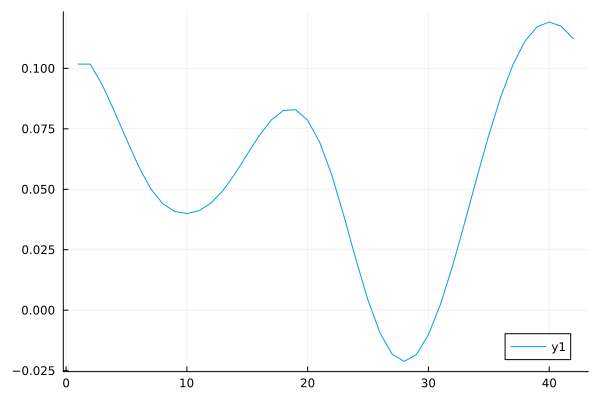

In [1674]:
plot(all_Δxtraj[1,41:82])

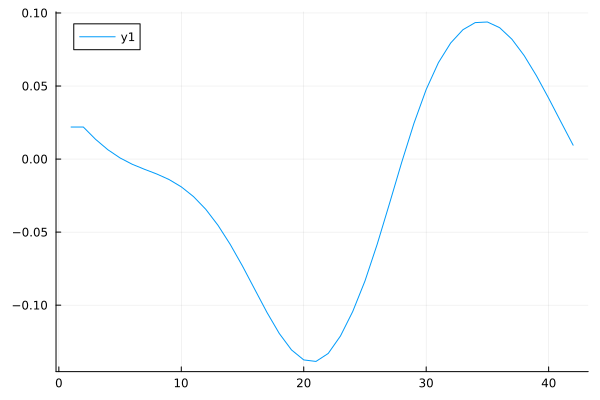

In [1675]:
plot(all_Δxtraj[2,41:82])

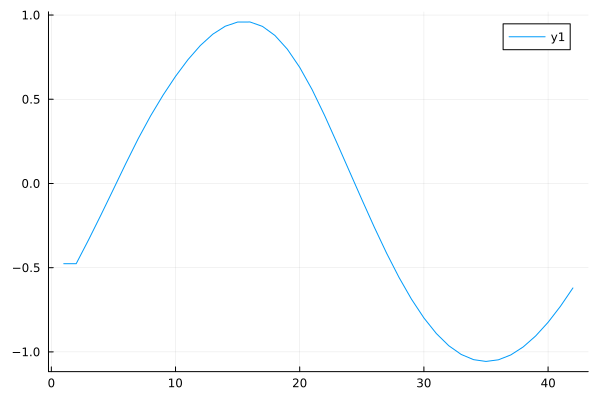

In [1676]:
plot(all_Δxtraj[3,41:82])

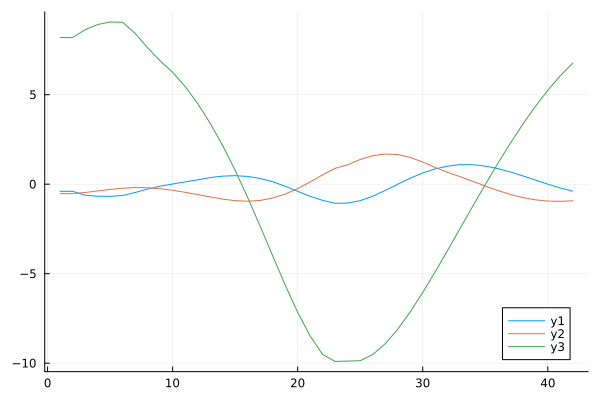

In [1677]:
plot(all_Δxtraj[4,41:82])
plot!(all_Δxtraj[5,41:82])
plot!(all_Δxtraj[6,41:82])

In [1678]:
#the Δt is in SI units (days)

In [1680]:
#integrate over the timestep to get the velocity cost in km/day
x_cost = sum(abs.(scaled_control[1,:]))*(Δt)
y_cost = sum(abs.(scaled_control[2,:]))*(Δt)
z_cost = sum(abs.(scaled_control[3,:]))*(Δt)

198.74284462401246

In [1681]:
x_cost

277.04354683355297

In [1682]:
25e-3*86400^2*Δt/86400

36.46178680196209

In [1683]:
#velocity cost in m/s
#dividing by 86400 to get into seconds bc currently it is in days

#units are good (checked in simulation_test)
x_cost_ms = x_cost*(1e3/86400)
y_cost_ms = y_cost*(1e3/86400)
z_cost_ms = z_cost*(1e3/86400)

display(x_cost_ms)
display(y_cost_ms)
display(z_cost_ms)

3.2065225327957516

0.9612645553843526

2.3002644053705144

In [1684]:
all_cost = x_cost_ms + y_cost_ms + z_cost_ms 

6.468051493550618

In [1685]:
cost_per_rev = all_cost/orbit_num

0.06468051493550618

In [1686]:
# #Exclude the first 10 timesteps to fix the injection error
# x_cost_good = sum(abs.(scaled_control[1,42:end]))*(Δt) *(1e3/86400)
# y_cost_good = sum(abs.(scaled_control[2,42:end]))*(Δt) *(1e3/86400)
# z_cost_good = sum(abs.(scaled_control[3,42:end]))*(Δt) *(1e3/86400)

# display(x_cost_good)
# display(y_cost_good)
# display(z_cost_good)

In [1687]:
# #cost for 95 revs
# all_cost_good = x_cost_good + y_cost_good + z_cost_good

In [1688]:
#final_mpc = reference_trajectory + optimal_x

In [1689]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")

In [1690]:
#initially
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]],[final_mpc[3,1]], label= "Start Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [1691]:
#plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], label = "MPC Trajectory")
#scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label= "Start Point")
#scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]], label= "End Point")

#plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], label="Reference Trajectory")

In [1692]:
#diff = final_mpc - reference_trajectory

In [1693]:
#plot(diff[1,:])
#plot!(diff[2,:])
#plot!(diff[3,:])

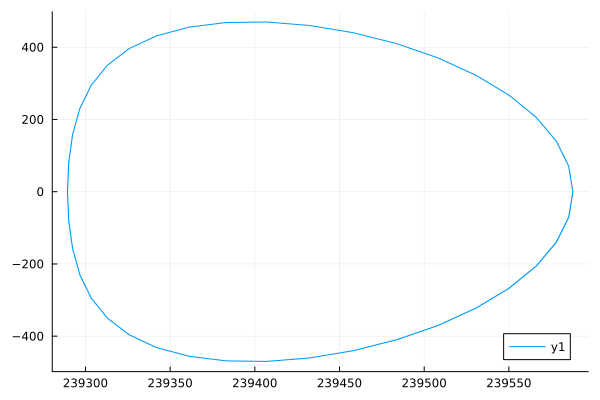

In [1694]:
plot(all_xtraj[1,:], all_xtraj[2,:])

In [1696]:
all_xtraj[:,end]

6-element Vector{Float64}:
 239587.80070956665
      0.07429631179286612
    225.3723940215826
     -0.1990268959119681
  -4205.592519852248
      6.114095357395342

In [1697]:
all_optimal_x[:,:,end]

6×21 Matrix{Float64}:
    2.39289e5     2.3929e5     2.39292e5  …      2.39585e5      2.39588e5
   -0.143196     79.9376     157.282            70.7974         0.0742963
 -175.19       -171.997     -162.356           223.248        225.372
   -0.742245     85.1275     188.182           291.128         -0.199027
 4771.41       4689.23      4449.86          -4157.8        -4205.59
   -7.89372     384.183      752.258      …    245.227          6.1141

In [1698]:
dot(all_optimal_x[:,end,end], unstable_directions_2[:,21])    

-16397.857190454386

In [1699]:
all_optimal_x

6×21×200 Array{Float64, 3}:
[:, :, 1] =
     2.39588e5        2.39585e5      2.39578e5  …     2.3929e5     2.39289e5
     2.88578e-15    -70.6926      -139.782          -80.4139      -0.327035
   226.168          224.186        218.238         -172.041     -175.536
    -9.46749e-10   -290.403       -570.955          -86.7819      -0.735898
 -4203.74         -4156.07       -4014.17          4689.11      4772.25
    -9.76991e-10   -234.515       -469.311      …  -402.189       -9.67305

[:, :, 2] =
    2.39289e5     2.3929e5     2.39292e5  …      2.39585e5      2.39588e5
   -0.327035     79.7687     157.129            70.7417         0.0219431
 -175.536      -172.365     -162.734           223.53         225.692
   -0.735898     85.3225     188.478           290.851         -0.397314
 4772.25       4690.16      4450.77          -4157.64       -4205.36
   -9.67305     383.227      752.029      …    247.629          8.19211

[:, :, 3] =
     2.39588e5      2.39585e5      2.39578e5  …     2

In [1700]:
end_state = all_xtraj[:,end]

end_state_sim = just_dynamics_integrate(end_state, 2.15*sol_t_final[end])


end_state_traj = get_state(end_state_sim)

6×206 Matrix{Float64}:
     2.39588e5      2.39588e5  …       2.45047e5       2.45198e5
     0.0742963     -0.4649        -10951.7        -11690.5
   225.372        225.373           -156.519        -139.49
    -0.199027      -2.42425        10860.3         10110.1
 -4205.59       -4205.59          -50481.6        -52134.8
     6.1141         4.29274    …    1161.93         1202.84

In [1701]:
2.15*sol_t_final[end]

1.4517192893373796

In [1702]:
sol_t_final[end] 

0.6752182741104091

In [1703]:
sol_t_final[end]*2.15*24

34.84126294409711

In [1704]:
#testing
#end_state_sim = reference_trajectory[:,end]

In [1705]:
delta_end = end_state - reference_trajectory[:,end]

6-element Vector{Float64}:
  0.17327425145776942
  0.07429627095887371
 -0.796048797647785
 -0.19902563655656
 -0.7610292395902434
  6.114095568744288

In [1706]:
#end_state_test = reference_trajectory[:,end] - delta_end

In [1707]:
#correct_end_state = end_state_test - reference_trajectory[:,end]

In [1708]:
#end_state_sim_correct = just_dynamics_integrate(end_state_test, 2.0*sol_t_final[end])


#end_state_traj_correct = get_state(end_state_sim_correct)

In [1709]:
deltaaa = xtraj_test[:,1:21] - all_xtraj[:,1:21]

6×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

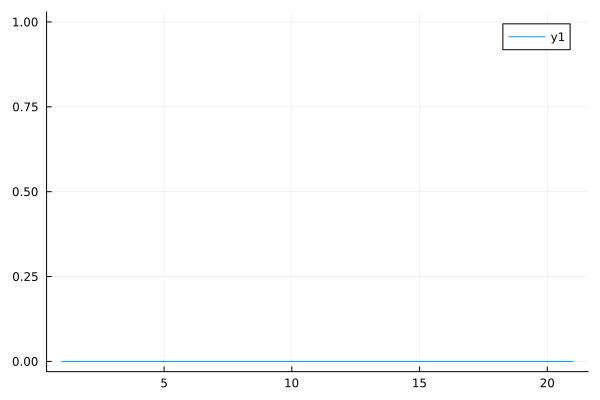

In [1710]:
plot(deltaaa[6,:])

In [1711]:
half_test = all_xtraj[:,1:21] - reference_trajectory[:,1:21]

6×21 Matrix{Float64}:
 0.238529  0.2444     0.253665   …   0.0313443   0.0206907   0.00879526
 0.0       0.017962   0.0337294     -0.340568   -0.33869    -0.327035
 0.0       0.0464555  0.151029       0.496383    0.350071    0.191108
 0.0       0.698645   0.404138      -0.593401   -0.669553   -0.735895
 1.08967   1.01263    0.854265      -0.175482    0.40512     0.97339
 0.0       5.49672    6.87601    …  -8.18478    -9.09922    -9.67305

In [1712]:
constraint_check_test = zeros(21)
for i=1:21
    constraint_check_test[i] = dot(half_test[:,i], unstable_directions[:,i])

end


In [1713]:
constraint_check_test

21-element Vector{Float64}:
  0.44036580060833785
 -0.9998937014720303
 -0.9997551343889834
 -0.9995973999283893
 -0.9994521850361142
 -0.9993728058744273
 -0.9993734189075794
 -0.9995062435253952
 -0.999802136341182
 -1.0002927667407275
  ⋮
 -1.0247534854042168
 -1.0048294901612695
 -1.0067385933529138
 -1.0089775781721544
 -1.0115220643638387
 -1.014319836787779
 -1.0172985633182763
 -1.020391938451601
 -1.02357935897719

In [1714]:
#check the constraint...
constraint_check = zeros(4100)
for k=1:100
    for i=1:41

        constraint_check[41*(k-1)+i] = dot(unstable_directions[:,i], all_Δxtraj[:, 41*(k-1)+i]) #> 0 

    end
end

In [1715]:
constraint_check[1600:1625]

26-element Vector{Float64}:
 -1.0610006535275636
 -1.0005446383012737
 -1.0009835335837338
 -1.0013307159176386
 -1.0016090971122578
 -1.0018508854016734
 -1.002097975720794
 -1.0024022717619752
 -1.0028278990558923
 -1.0466539411253455
  ⋮
 -1.028958111647718
 -1.0364917058548897
 -1.0451210408105727
 -1.0547043700558485
 -1.0033143849835853
 -1.001349433714361
 -1.0016865759035831
 -1.0019713017764067
 -1.0023394704913504

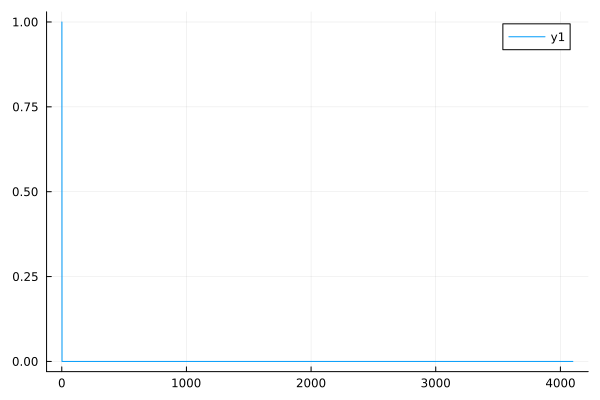

In [1716]:
plot(constraint_check.>0)

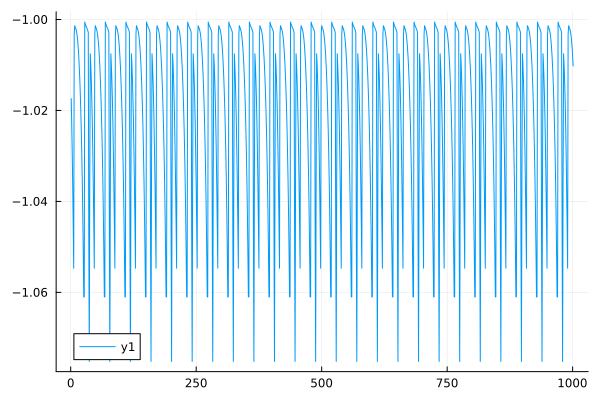

In [1717]:
plot(constraint_check[1000:2000])

In [1718]:
constraint_check[1:15]

15-element Vector{Float64}:
  0.44036580060833785
 -0.9998937014720303
 -0.9997551343889834
 -0.9995973999283893
 -0.9994521850361142
 -0.9993728058744273
 -0.9993734189075794
 -0.9995062435253952
 -0.999802136341182
 -1.0002927667407275
 -1.0010102583590106
 -1.0203450055578394
 -1.0247534854042168
 -1.0048294901612695
 -1.0067385933529138

In [1719]:
0.77 * 1e3/86400

0.008912037037037038

In [1720]:
constraint_check[50:75]

26-element Vector{Float64}:
 -1.0012175432776176
 -1.0018895282739346
 -1.004291110687228
 -1.02727057133976
 -1.0402053443887886
 -1.0431771803887617
 -1.0380902981225588
 -1.0285686772418288
 -1.0190894714230683
 -1.0241945217459707
  ⋮
 -1.0013400939885861
 -1.0020053666547672
 -1.002958664660774
 -1.0042111345374591
 -1.005768665113457
 -1.0076408938363137
 -1.0098464556960185
 -1.0124163707649545
 -1.0153960245518132

In [1721]:
#going to check what happens if I simulate the 4000 controls on the scaled model
all_utraj

3×4000 Matrix{Float64}:
  -2.65276    -63.1859     -50.0483      …  -10.1108       -9.59415
  -1.8505e-9   -2.9899e-9   -7.15413e-9      -1.81826e-10  -1.19926e-10
 320.28        81.0107       2.71165e-8       7.66189e-11   3.40963e-11

In [1722]:
xtraj_test = integrate_oneperiod(all_xtraj[:,1], all_utraj[:,1:40])

6×41 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.6926           70.7417         0.0219431
   226.168          224.186           223.53         225.692
    -9.46749e-10   -290.403           290.851         -0.397314
 -4203.74         -4156.07          -4157.64       -4205.36
    -9.76991e-10   -234.515      …    247.629          8.19211

In [1723]:
Δt/time_scale

0.07711476085647354

In [1724]:
norm(xtraj_test[1:3,end]- xtraj_test[1:3,1])/L

2.0805493030861437e-6

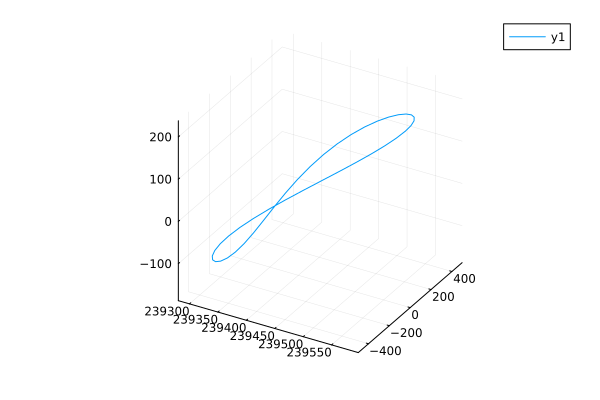

In [1725]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:])

In [1726]:
unstable_directions[:,end]


#for the negative manifold, the final state is satisfying the constraint and that's why it goes to the 
#left 

#however, for the positive manifold, it is satisfying the negative manifold constraint...

6-element Vector{Float64}:
 -0.08855910684745631
  0.028657440897460223
 -0.005939290756903622
 -0.8887776057645703
  0.42351375489949117
 -0.14836181248294963

In [1727]:
dot(delta_end, unstable_directions[:,end])

-1.0610030290644752

In [1728]:
# #check this constraint 
# #works with pi/5 too 

# c_test = unstable_directions[:,end]/tan(pi/6)
# #c_test = unstable_directions[:,end]/tan((pi/2) - deg2rad(60))

# manifold_constraint_test = norm(delta_end) - c_test'*(delta_end)

# manifold_constraint_test
# #push!(cons, manifold_constraint <= 0)

In [1729]:
#angle away from the unstable manifold
dot(unstable_directions[:,end], delta_end)*norm(delta_end)*180/pi

-378.030940645512

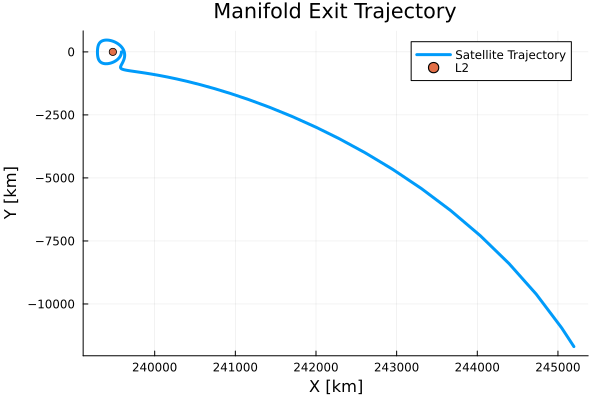

In [1730]:
#escapes on the right for positive unstable direction!
manifold_exit = plot(end_state_traj[1,:], end_state_traj[2,:], title= "Manifold Exit Trajectory", linewidth=3, 
xlabel = "X [km]", ylabel = "Y [km]", label = "Satellite Trajectory")
scatter!([XL2[1]*L], [XL2[2]], label="L2")


In [1731]:
#savefig(manifold_exit, "manifold_exit_saturn_enceladus")

In [1732]:
#plot(end_state_traj_correct[1,:], end_state_traj_correct[2,:])

#goes to the right when it is in the positive manifold direction. hypothesis is true. however, 
#the solver is giving solutions that does not satisfy this constraint. need to figure out why...

In [1733]:
#needs to be a super small perturbation in order to stay stable

forward_rollout = zeros(6, N_period)

#forward_rollout[:,1] = [1e-3, 0, 0, 0, 1e-6,0]


forward_rollout[:,1] = [1e-9, 0, 0, 0, 1e-9, 0]

for i=1:N_period-1
   
    #diverges with no control 
    #forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i]
    
    #with disturbances it just blows up
    forward_rollout[:,i+1] = all_Ad[:,:,i]*forward_rollout[:,i] #+ randn(6)*1e-4
    
end
    

In [1734]:
reference_trajectory

6×41 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.7106           70.7106         4.0834e-8
   226.168          224.14            224.14         226.168
    -9.46749e-10   -291.102           291.102         -1.25936e-6
 -4204.83         -4157.08          -4157.08       -4204.83
    -9.76991e-10   -240.012      …    240.012         -2.11349e-7

In [1735]:
nocontrol = forward_rollout + reference_trajectory

6×41 Matrix{Float64}:
     2.39588e5        2.39585e5  …      2.39585e5      2.39588e5
     2.88578e-15    -70.7106           70.7106        -2.3479e-7
   226.168          224.14            224.14         226.168
    -9.46749e-10   -291.102           291.102          7.28209e-6
 -4204.83         -4157.08          -4157.08       -4204.83
    -9.76991e-10   -240.012      …    240.012          1.21543e-6

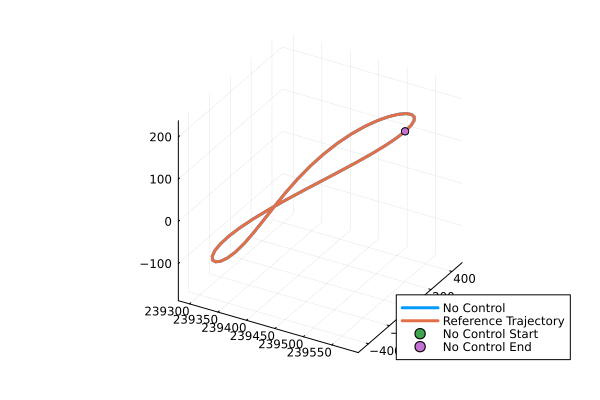

In [1736]:
plot(nocontrol[1,:], nocontrol[2,:], nocontrol[3,:], lw=3, label="No Control")
plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
scatter!([nocontrol[1,1]], [nocontrol[2,1]], [nocontrol[3,1]], label="No Control Start")
scatter!([nocontrol[1,end]], [nocontrol[2,end]],[nocontrol[3,end]], label="No Control End")

In [ ]:
# plot(final_mpc[1,:], final_mpc[2,:], final_mpc[3,:], lw=3, label="MPC Control")
# plot!(reference_trajectory[1,:], reference_trajectory[2,:], reference_trajectory[3,:], lw=3, label="Reference Trajectory")
# scatter!([final_mpc[1,1]], [final_mpc[2,1]], [final_mpc[3,1]], label="No Control Start")
# scatter!([final_mpc[1,end]], [final_mpc[2,end]], [final_mpc[3,end]],  label="No Control End", aspectratio = true)

In [ ]:
position_tube_norm = zeros(N_period*orbit_num)

velocity_tube_norm = zeros(N_period*orbit_num)

In [ ]:
orbit_num

In [ ]:
svd(V[:,:,1]).S

In [ ]:
for i=1:N_period*orbit_num
   
    position_tube_norm[i]= norm(all_Δxtraj[1:3,i])
    
    velocity_tube_norm[i]= norm(all_Δxtraj[4:6,i])
    
end

In [ ]:
ctg_constraint = zeros(6, N_period)
dist_from_center = zeros(6, N_period)

In [ ]:
(ones(6).*0.1)./eigen(V[:,:,1]).values

In [ ]:
test_v = (ones(6).*0.1)./eigen(V[:,:,1]).vectors

In [ ]:
test_v * [1,1,1,0,0,0]

In [ ]:
V

In [ ]:
for i= 1:N_period

    e_decomp = eigen(V[:,:,i])

    #inverse same as transpose in this case
    y = inv(e_decomp.vectors) * all_Δxtraj[:,i]

    dist_from_center[:,i] = y

    ctg_constraint[:,i] = sqrt.(1e-3 .*ones(6)./e_decomp.values)


end

    

In [ ]:
ctg_constraint


In [ ]:
dist_from_center

In [ ]:
all_Δxtraj[:,1]'*V[:,:,1]*all_Δxtraj[:,1]

In [ ]:
dist_from_center[1,:]*L

In [ ]:
plot(dist_from_center[1,:], label="x")
plot!(ctg_constraint[1,:], label="x axis constraint")

In [ ]:
plot(dist_from_center[2,:], label="y")
plot!(ctg_constraint[2,:], label="y axis constraint")

In [ ]:
plot(dist_from_center[3,:], label="z")
plot!(ctg_constraint[3,:], label="z axis constraint")

In [ ]:
plot(dist_from_center[4,:], label="vx")
plot!(ctg_constraint[4,:], label="vx axis constraint")

In [ ]:
plot(dist_from_center[5,:], label="vy")
plot!(ctg_constraint[5,:], label="vy axis constraint")

In [ ]:
plot(dist_from_center[6,:], label="vz")
plot!(ctg_constraint[6,:], label="vz axis constraint")

In [ ]:
all_Δxtraj[:,1]

In [ ]:
V[:,:,1]

In [ ]:
#test.vectors*diagm(test.values)*test.vectors'

In [ ]:
#inv(test.vectors)

In [ ]:
#test.vectors'

In [ ]:
# #finding the magnitude of the principle axes of the ellipsoid
# magnitude_principle_axes = zeros(6, N_period)


# for i=1:N_period
    
#     magnitude_principle_axes[:,i] = svd(V[:,:,i]).S
    
    
# end

In [ ]:
# plot(magnitude_principle_axes[1,:])
# plot!(magnitude_principle_axes[2,:])
# plot!(magnitude_principle_axes[3,:])

In [ ]:
# plot(magnitude_principle_axes[4,:])
# plot!(magnitude_principle_axes[5,:])
# plot!(magnitude_principle_axes[6,:])

In [ ]:
plot(all_Δxtraj[1,:])

plot!(all_Δxtraj[2,:])

plot!(all_Δxtraj[3,:])

In [ ]:
plot(all_Δxtraj[4,:])

plot!(all_Δxtraj[5,:])

plot!(all_Δxtraj[6,:])